### PAD S21415 
### Wstępna analiza danych i czyszczenie

#### Importy


In [449]:
# Praca z danymi
import pandas as pd
import numpy as np
import scipy
import sklearn
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score



# Wizualizacja
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno



##### Konfiguracja wizualizacji
Tak, żeby wykresy były bardziej czytelne

In [450]:
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

### Funkcje 

In [451]:
# Funkcja do obliczania metryk
def calculate_metrics(y_true, predictions, X):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mae = mean_absolute_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)
    adjusted_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X.shape[1] - 1)
    return rmse, mae, r2, adjusted_r2


#### Załadowanie danych do data frame'a i ich wyświetlenie
Zbadajmy pierwsze 100 rekordów

In [452]:
df = pd.read_csv('messy_data.csv')
print(f'Ilość rekordów: {len(df. index)}')
df.head(100)


Ilość rekordów: 200


,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.50,IF,D,Ideal,5.1,5.15,3.2,61.5,,3000
1,0.70,vvs2,E,premium,5.7,,3.52,62,59,4500
2,NaN,Si2,h,Good,4.3,4.31,,62.3,56,700
3,1.20,if,d,ideal,,6.82,4.2,61.7,58,10000
4,0.90,I1,J,Fair,6,,3.7,61.7,,2400
...,...,...,...,...,...,...,...,...,...,...
95,NaN,vvs2,D,good,6.4,6.42,3.97,,,8000
96,0.75,si1,I,Very good,5.9,5.88,3.65,62.3,,4400
97,1.40,VVS1,e,Premium,7.1,,4.40,62.7,58,11500
98,NaN,i1,F,Good,5.9,5.89,,62.8,55,2500


### Opis kolumn w kontekscie diamentów

- **carat**: 
  Jednostka masy dla diamentów, równa 200 miligramom. Wpływa na wartość diamentu; im większy karat, tym wyższa wartość.

- **x dimension**: 
  Długość diamentu w milimetrach, mierzona poziomo od jednego końca do drugiego.

- **y dimension**: 
  Szerokość diamentu, mierzona w milimetrach, od strony do strony.

- **z dimension**: 
  Głębokość diamentu, mierzona w milimetrach, od góry do dołu.

- **depth**: 
  Wysokość diamentu jako procent stosunku głębokości do średnicy lub po prostu w milimetrach, wpływa na błysk diamentu.

- **table**: 
  Płaska górna powierzchnia diamentu. Jej rozmiar ma wpływ na jakość szlifu.

- **price**: 
  Cena diamentu, ustalana na podstawie wszystkich jego cech, w tym karatów, szlifu, czystości i koloru.


#### Typ danych i kolumny

In [453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carat         150 non-null    float64
 1    clarity      200 non-null    object 
 2    color        200 non-null    object 
 3    cut          200 non-null    object 
 4    x dimension  200 non-null    object 
 5    y dimension  200 non-null    object 
 6    z dimension  200 non-null    object 
 7    depth        200 non-null    object 
 8    table        200 non-null    object 
 9    price        200 non-null    object 
dtypes: float64(1), object(9)
memory usage: 15.8+ KB


Jak widać Python potraktował typy kolumn jako obiektowe, pomimo że są to dane numeryczne. Należy to obsłużyć

#### Rozkład danych numerycznych i konwersja typów danych
Kolumny posiadają znaki białe przed ich nazwami. Należy to oczyścić. Następnie należy zbadać typy danych i je skorygować. Tak aby można było w następnej fazie na nich pracować

In [454]:
print(df.columns)
df = df.rename(columns=lambda x: x.strip())  # Usuwa białe znaki z początku i końca nazw

df['x dimension'] = pd.to_numeric(df['x dimension'], errors='coerce')
df['y dimension'] = pd.to_numeric(df['y dimension'], errors='coerce')
df['z dimension'] = pd.to_numeric(df['z dimension'], errors='coerce')
df['depth'] = pd.to_numeric(df['depth'], errors='coerce')
df['table'] = pd.to_numeric(df['table'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df.describe()

Index(['carat', ' clarity', ' color', ' cut', ' x dimension', ' y dimension',
       ' z dimension', ' depth', ' table', ' price'],
      dtype='object')


,carat,x dimension,y dimension,z dimension,depth,table,price
count,150.000000,197.000000,136.000000,152.000000,133.000000,167.000000,196.000000
mean,0.799000,5.885787,5.829706,3.694671,62.316541,56.910180,11410.714286
std,0.321827,0.770172,0.767402,0.462431,0.326408,1.421972,40072.669086
min,0.200000,3.900000,3.890000,2.410000,61.200000,54.000000,500.000000
25%,0.512500,5.300000,5.290000,3.350000,62.100000,56.000000,2600.000000
50%,0.750000,5.900000,5.850000,3.715000,62.300000,57.000000,4350.000000
75%,1.050000,6.500000,6.512500,4.082500,62.600000,58.000000,7900.000000
max,1.600000,7.300000,7.280000,4.500000,63.000000,60.000000,350000.000000


powyżej znajdują się dane statystyczne na kolumnach (przed ich oczyszczeniem oraz uzupełnieniem/skasowaniem braków)

#### Brakujące wartości

In [455]:
missing = df.isnull().sum()
print('Brakujące wartości: \n')
print(missing)
print('\nProcent brakujących wartości w każdej kolumnie: ')
total = len(df)
missing_percent = (df.isnull().sum() / total) * 100
print(missing_percent)
total_missings = df.isnull().sum().sum()
total_missing_percentage = (total_missings / (total * df.shape[1])) * 100
print(f'\nProcent całkowitej liczby pustych wartości: {round(total_missing_percentage,2)}%')


Brakujące wartości: 

carat          50
clarity         0
color           0
cut             0
x dimension     3
y dimension    64
z dimension    48
depth          67
table          33
price           4
dtype: int64

Procent brakujących wartości w każdej kolumnie: 
carat          25.0
clarity         0.0
color           0.0
cut             0.0
x dimension     1.5
y dimension    32.0
z dimension    24.0
depth          33.5
table          16.5
price           2.0
dtype: float64

Procent całkowitej liczby pustych wartości: 13.45%


Nasz zbiór danych jest mały, dlatego 13.45% uznaję jako wysoki procent braków w kolumnach

# Strategia uzupełniania brakujących danych

1. **Karata (50 brakujących)**: Rregresja do oszacowania na podstawie innych wymiarów.

2. **Wymiary X, Y, Z (3, 64, 48 brakujących)**: Estymacja na podstawie dostępnych danych.

3. **Głębokość (67 brakujących)**: Średnia/mediana lub obliczenia, jeśli wymiary X, Y, Z są dostępne.

4. **Tabela (33 brakujące)**: Średnią/mediana.

5. **Cena (4 brakujące)**: Usunąć lub szacunek regresją.

Dane zostną uzupełnione w następnych krokach po zbadaniu ich dokładniej



### Znalezienie duplikatów

In [456]:
duplicate_rows = df[df.duplicated(keep=False)]
number_of_duplicates = duplicate_rows.shape[0]

print(f'Liczba duplikatów w danych: {number_of_duplicates}')

Liczba duplikatów w danych: 0


W naszym zbiorze nie występują duplikaty. Nie musimy czyścić z nich danych

#### Analiza wartości odstających

Wykorzystamy wykresy pudełkowe do zidentyfikowania potencjalnych wartości odstających w naszych danych.



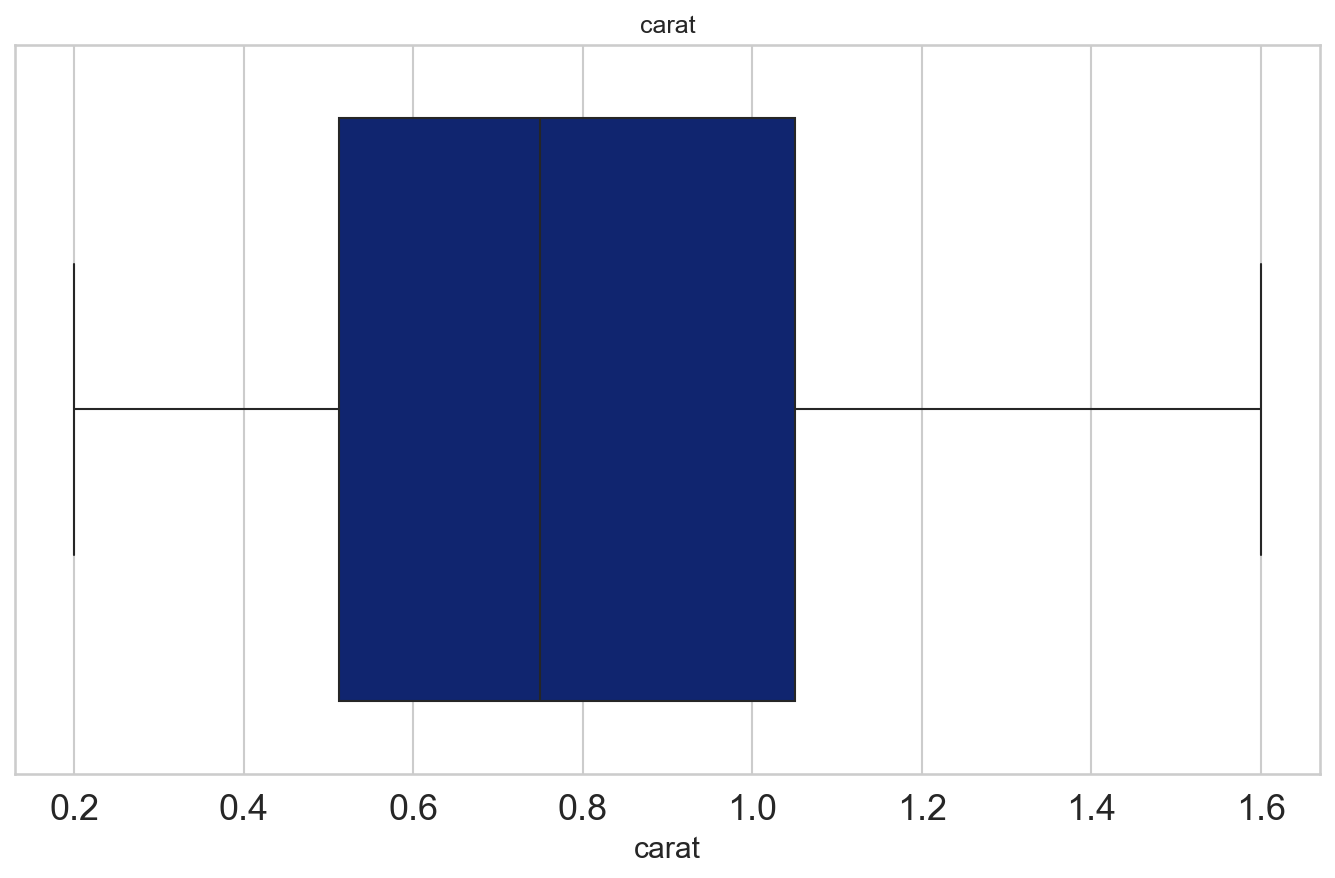

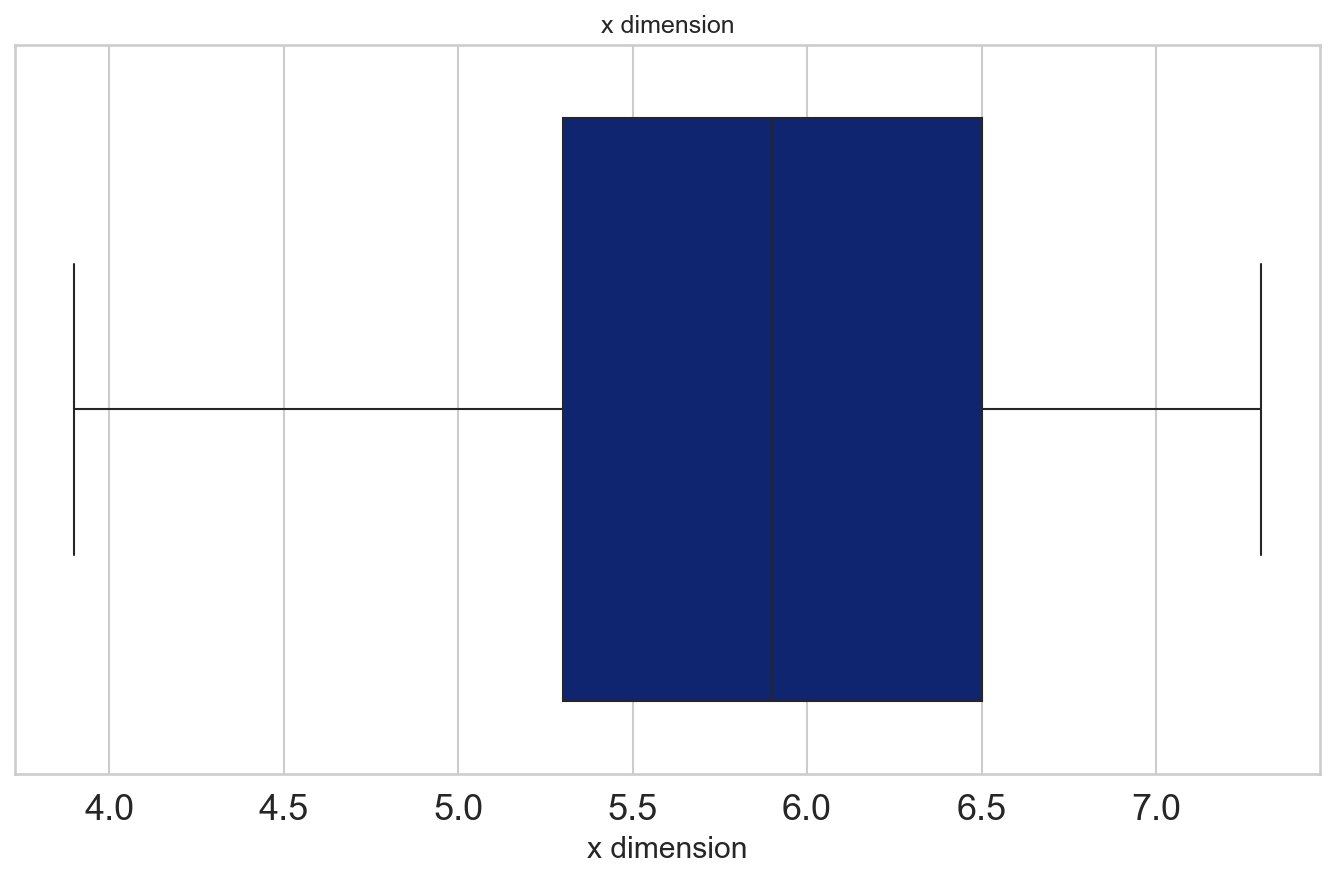

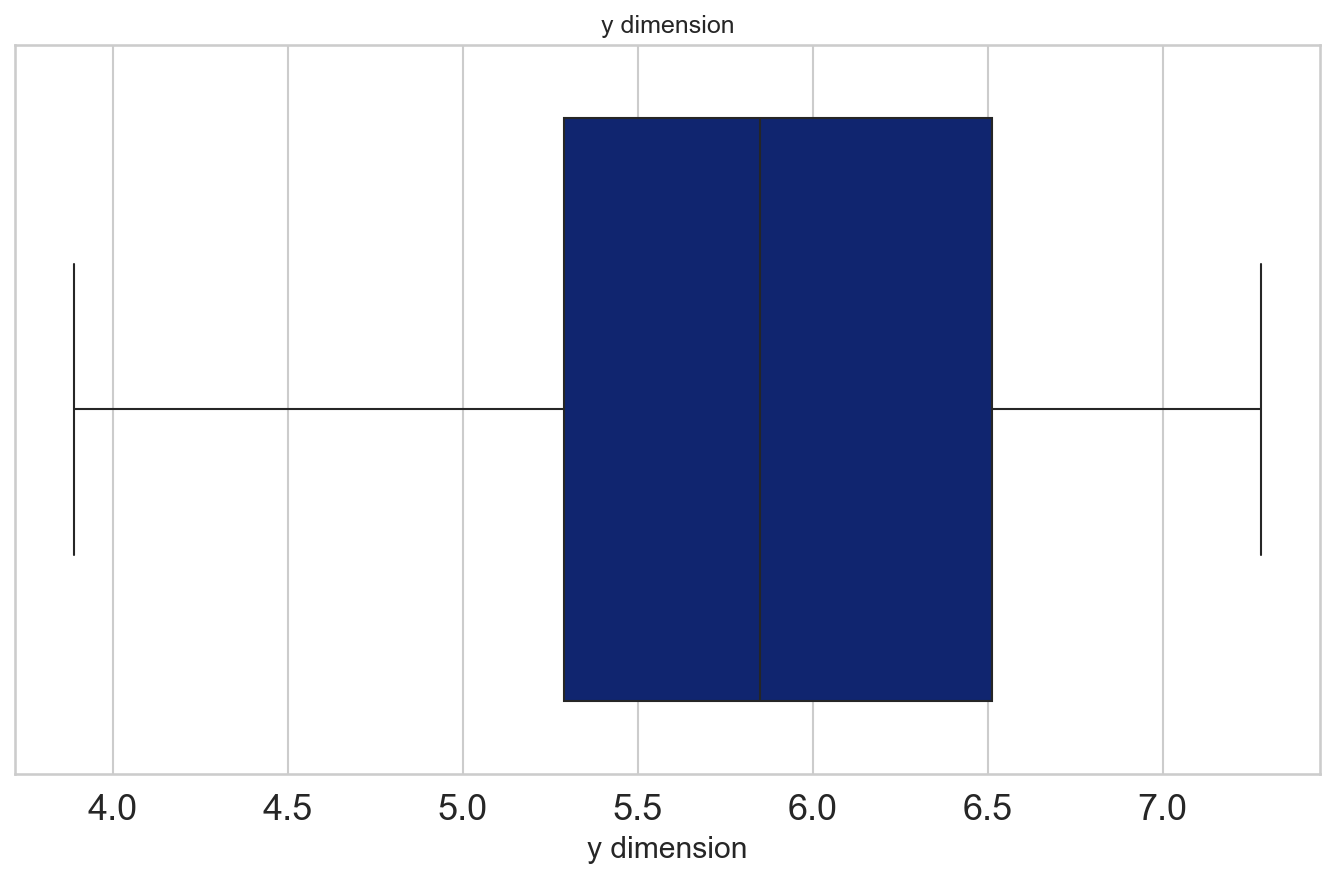

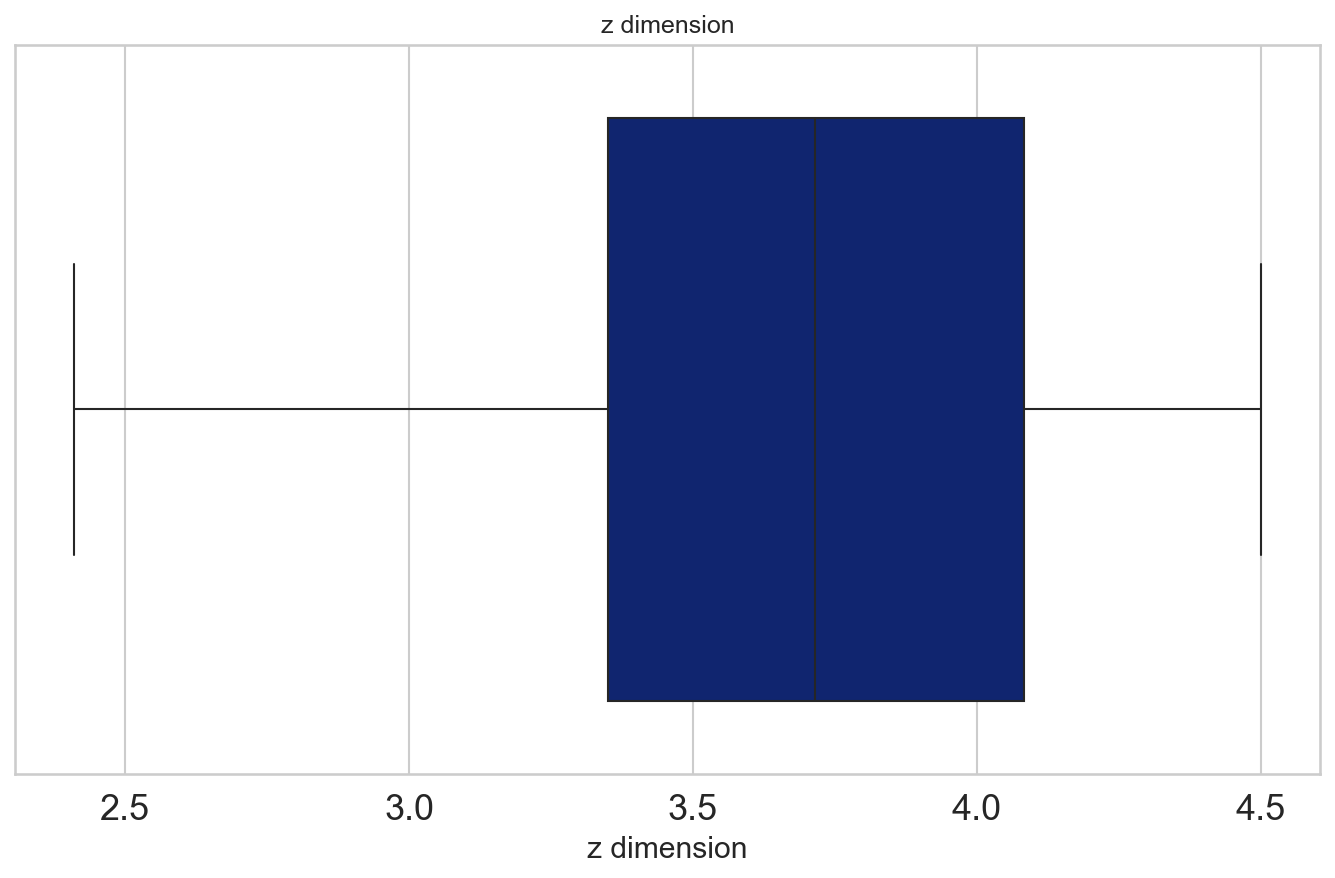

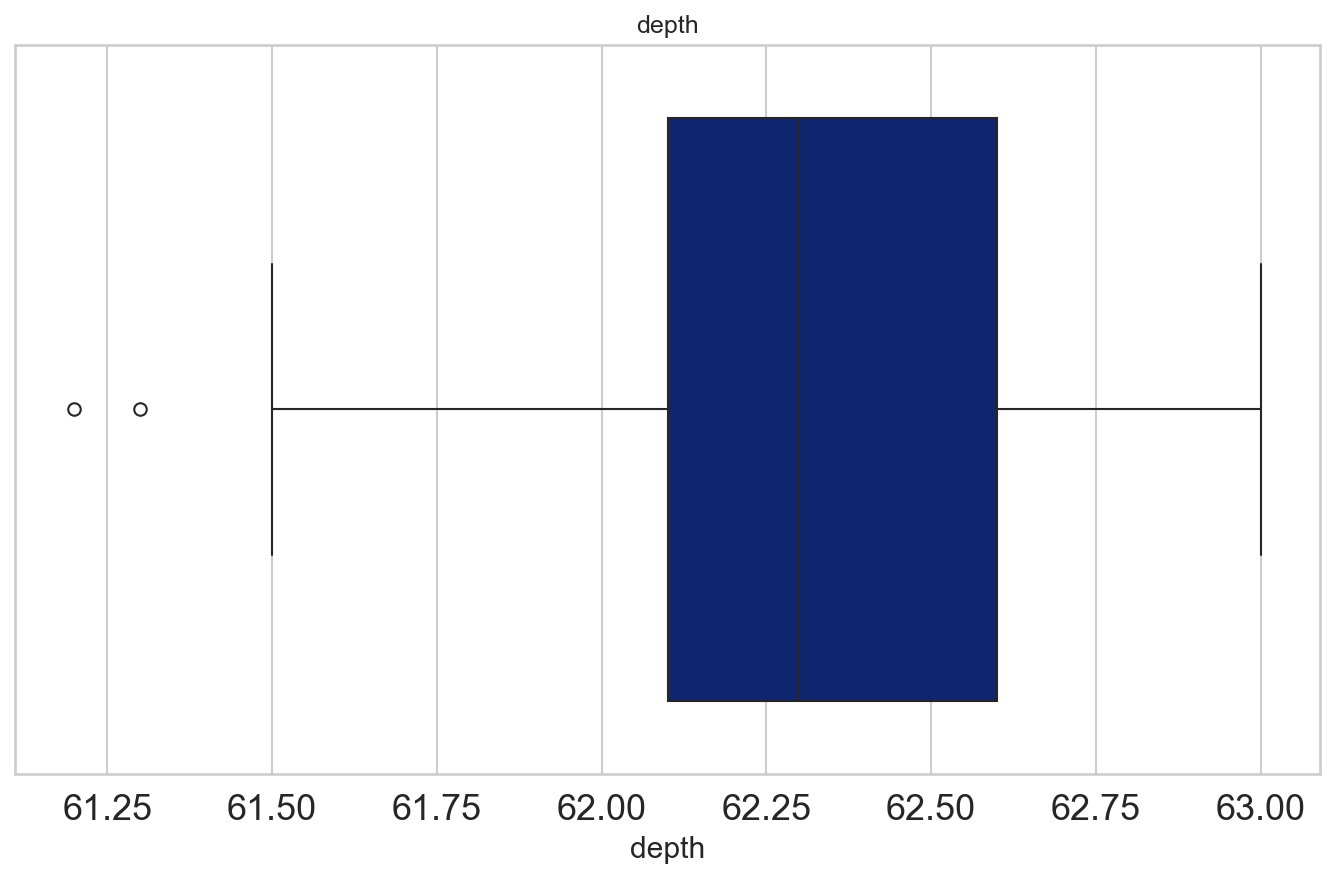

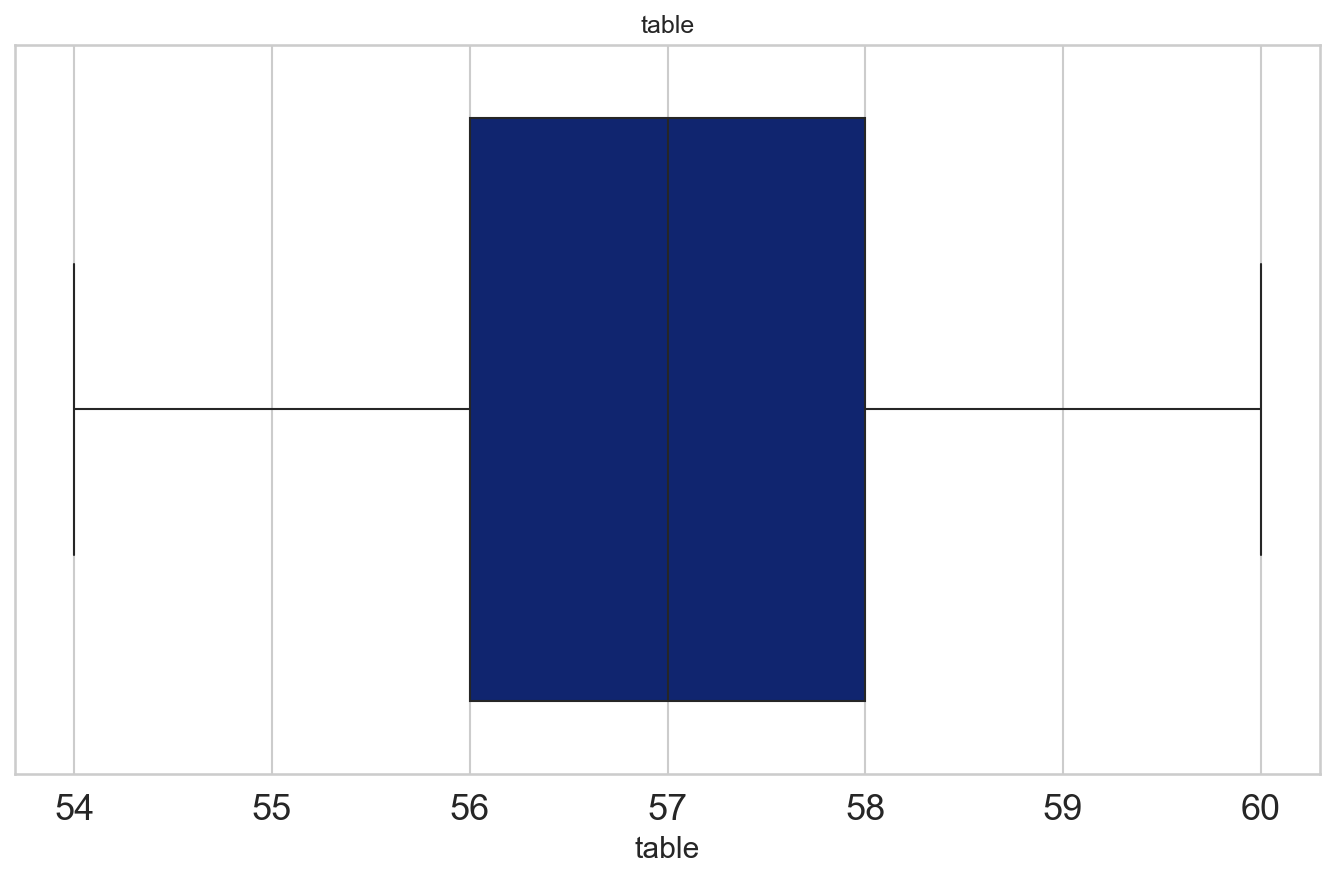

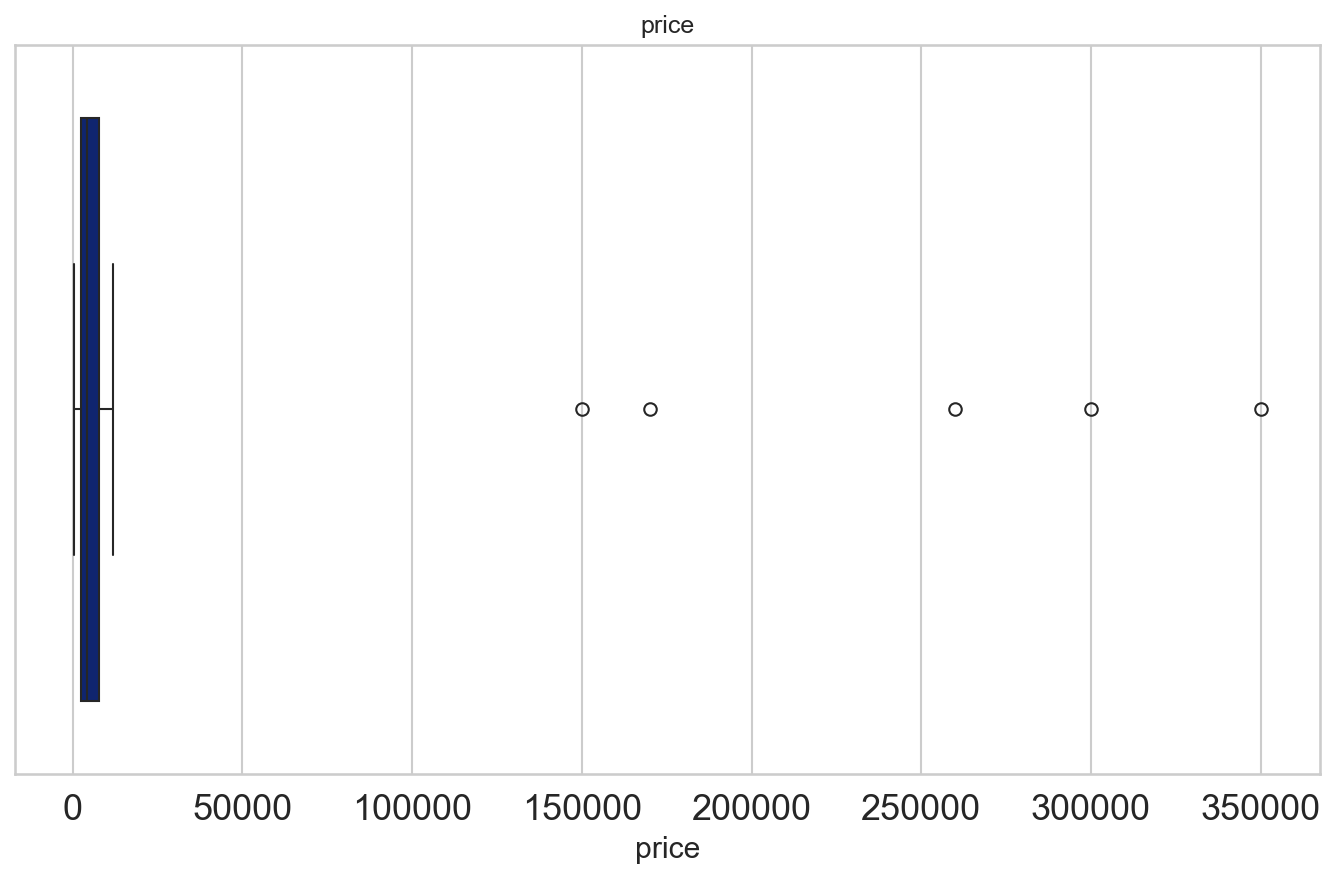

In [457]:

features = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(feature)
    plt.show()

###### Z wykresów wynika że zmienna price i zmienna depth mają wartości odstające. Należy je zbadać
#### Wartości odstające
##### Poza wąsy wykresów pudełkowych

In [458]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    if not outliers.empty:
        print(f"Wartości odstające dla kolumny {column}:")
        print(outliers, '\n')

Wartości odstające dla kolumny depth:
    carat clarity color         cut  x dimension  y dimension  z dimension  \
11    0.4    vvs2     G   Very good          4.9         4.88          NaN   
15    NaN    vvs2     I        Good          4.4         4.39         2.69   

    depth  table   price  
11   61.2   56.0  1400.0  
15   61.3   57.0     NaN   

Wartości odstające dla kolumny price:
     carat clarity color         cut  x dimension  y dimension  z dimension  \
182    NaN      i1     G       Ideal          5.2         5.24         3.23   
184   1.40     Si2     D   Very good          7.3          NaN         4.50   
187   0.90      IF     G   very good          6.3          NaN         3.90   
189    NaN    VVS2     D        fair          6.7          NaN         4.14   
197   0.55      i1     I     Premium          5.3          NaN         3.28   

     depth  table     price  
182    NaN   57.0  170000.0  
184   62.6   59.0  350000.0  
187    NaN   57.0  260000.0  
189   62.2 

#### Macierz korelacji między zmiennymi

Przed uzupełnieniem braków


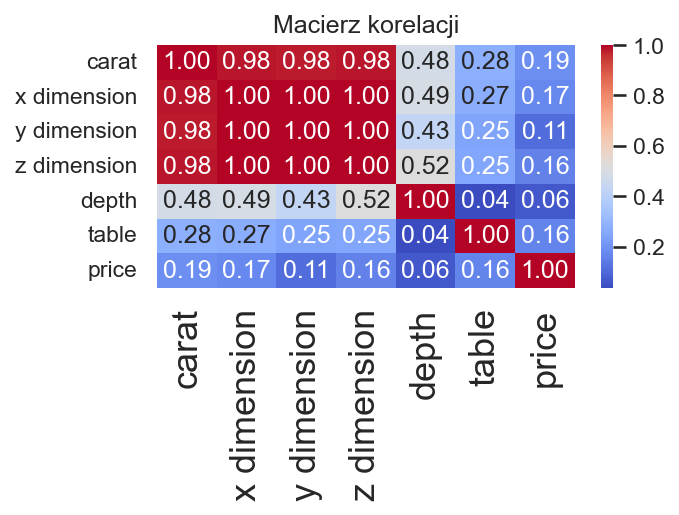

In [459]:
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix_before = df_numeric.corr()

plt.figure(figsize=(4, 2))
sns.heatmap(correlation_matrix_before, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()


#### Uzupełnienie brakujących wartości dla x dimension (Regrersja liniowa)

In [460]:
#Kopia danych przed wstawiniem brakujących danych
df_before_input = df.copy()

# Wyznacznie zbioru bez wartości NAN/Null
train_data_x = df.dropna(subset=['x dimension', 'y dimension', 'z dimension'])
X_train_x = train_data_x[['y dimension', 'z dimension']]
y_train_x = train_data_x['x dimension']
# Regresja liniowa
model_x = LinearRegression()
model_x.fit(X_train_x, y_train_x)

# Wyznaczenie zboru gdzie 'x dimension' jest NAN ale 'y dimension' i 'z dimension' nie sa NAN
predict_data = df[df['x dimension'].isna() & df['y dimension'].notna() & df['z dimension'].notna()]
num_rows = len(predict_data)
print("Number of rows for prediction:", num_rows)
X_predict = predict_data[['y dimension', 'z dimension']]

predict_data_indices = predict_data.index

predicted_x = model_x.predict(X_predict)

# Aktualizacja oryginalnego df'u
for i, index in enumerate(predict_data_indices):
    df.at[index, 'x dimension'] = predicted_x[i]
    print(f"Predykcja dla indeksu {index}: {predicted_x[i]}")

Number of rows for prediction: 3
Predykcja dla indeksu 3: 6.806717133839215
Predykcja dla indeksu 10: 5.2077983700673105
Predykcja dla indeksu 19: 5.784524663610592


#### Uzupełnienie brakujących wartości dla y dimension (regresja liniowa)

In [461]:
# Wyznacznie zbioru bez wartości NAN/Null
train_data_y = df.dropna(subset=['y dimension','x dimension', 'z dimension'])
X_train_y = train_data_y[['x dimension', 'z dimension']]
y_train_y = train_data_y['y dimension']
# Regresja liniowa
model_y = LinearRegression()
model_y.fit(X_train_y, y_train_y)

# Wyznaczenie zboru gdzie 'x dimension' jest NAN ale 'y dimension' i 'z dimension' nie sa NAN
predict_data_y = df[df['y dimension'].isna() & df['x dimension'].notna() & df['z dimension'].notna()]
num_rows = len(predict_data_y)
print("Number of rows for prediction:", num_rows)
Y_predict = predict_data_y[['x dimension', 'z dimension']]

predict_data_indices_y = predict_data_y.index

predicted_y = model_y.predict(Y_predict)

# Aktualizacja oryginalnego df'u
for i, index in enumerate(predict_data_indices_y):
    df.at[index, 'y dimension'] = predicted_y[i]
    print(f"Predykcja dla indeksu {index}: {predicted_y[i]}")

Number of rows for prediction: 64
Predykcja dla indeksu 1: 5.694472528154446
Predykcja dla indeksu 4: 5.992341047512541
Predykcja dla indeksu 6: 5.123665329952526
Predykcja dla indeksu 9: 6.426893834094743
Predykcja dla indeksu 13: 6.600543006485868
Predykcja dla indeksu 16: 5.185560075633817
Predykcja dla indeksu 21: 6.923341366358235
Predykcja dla indeksu 27: 4.583590576789058
Predykcja dla indeksu 30: 5.601415481830315
Predykcja dla indeksu 33: 6.904643985972531
Predykcja dla indeksu 37: 6.3026744871277725
Predykcja dla indeksu 39: 5.899284001188411
Predykcja dla indeksu 41: 6.203384980675073
Predykcja dla indeksu 45: 4.596055497046194
Predykcja dla indeksu 46: 5.402836468924918
Predykcja dla indeksu 51: 7.103222998877928
Predykcja dla indeksu 54: 6.898411525843963
Predykcja dla indeksu 57: 6.501253500033169
Predykcja dla indeksu 59: 5.303546962472219
Predykcja dla indeksu 64: 5.893051541059843
Predykcja dla indeksu 67: 5.297314502343651
Predykcja dla indeksu 71: 5.198024995890953
P

#### Uzupełnienie brakujących wartości dla z dimension (regresja liniowa)

In [462]:
# Wyznacznie zbioru bez wartości NAN/Null
train_data_z = df.dropna(subset=['z dimension','y dimension','x dimension'])
X_train_z = train_data_z[['y dimension', 'x dimension']]
y_train_z = train_data_z['z dimension']
# Regresja liniowa
model_z = LinearRegression()
model_z.fit(X_train_z, y_train_z)

# Wyznaczenie zboru gdzie 'x dimension' jest NAN ale 'y dimension' i 'z dimension' nie sa NAN
predict_data_z = df[df['z dimension'].isna() & df['y dimension'].notna() & df['x dimension'].notna()]
num_rows = len(predict_data_z)
print("Number of rows for prediction:", num_rows)
Z_predict = predict_data_z[['y dimension', 'x dimension']]

predict_data_indices_z = predict_data_z.index

predicted_z = model_z.predict(Z_predict)

# Aktualizacja oryginalnego df'u
for i, index in enumerate(predict_data_indices_z):
    df.at[index, 'z dimension'] = predicted_z[i]
    print(f"Predykcja dla indeksu {index}: {predicted_z[i]}")

Number of rows for prediction: 48
Predykcja dla indeksu 2: 2.6735904005872295
Predykcja dla indeksu 8: 2.679572429331454
Predykcja dla indeksu 11: 3.025323482085438
Predykcja dla indeksu 14: 3.277758289316914
Predykcja dla indeksu 17: 4.017116624778673
Predykcja dla indeksu 18: 3.418930764793211
Predykcja dla indeksu 22: 4.404741878742223
Predykcja dla indeksu 26: 2.8027988185750794
Predykcja dla indeksu 31: 4.4424269583871405
Predykcja dla indeksu 34: 3.043269568318109
Predykcja dla indeksu 35: 3.4009846785605404
Predykcja dla indeksu 38: 4.072747790656262
Predykcja dla indeksu 42: 3.6037703486586516
Predykcja dla indeksu 44: 3.7210147091580534
Predykcja dla indeksu 49: 3.5361751252926146
Predykcja dla indeksu 52: 2.735203595209043
Predykcja dla indeksu 53: 3.234091180927772
Predykcja dla indeksu 61: 3.7886099325240905
Predykcja dla indeksu 63: 3.5977883199144274
Predykcja dla indeksu 70: 3.8502231271459038
Predykcja dla indeksu 76: 4.281515489498596
Predykcja dla indeksu 82: 4.072747

#### Uzupełnienie brakujących wartości dla carat (regresja liniowa)


In [463]:
# Wyznacznie zbioru bez wartości NAN/Null
train_data_carat = df.dropna(subset=['carat','z dimension','y dimension','x dimension'])
X_train_carat = train_data_carat[['y dimension', 'x dimension', 'z dimension']]
y_train_carat = train_data_carat['carat']
# Regresja liniowa
model_carat = LinearRegression()
model_carat.fit(X_train_carat, y_train_carat)

predict_data_carat = df[df['carat'].isna() & df['y dimension'].notna() & df['x dimension'].notna()& df['z dimension'].notna()]
num_rows = len(predict_data_carat)
print("Number of rows for prediction:", num_rows)
carat_predict = predict_data_carat[['y dimension', 'x dimension', 'z dimension']]

predict_data_indices_carat = predict_data_carat.index

predicted_carat = model_carat.predict(carat_predict)

# Aktualizacja oryginalnego df'u
for i, index in enumerate(predict_data_indices_carat):
    df.at[index, 'carat'] = predicted_carat[i]
    print(f"Predykcja dla indeksu {index}: {predicted_carat[i]}")

Number of rows for prediction: 50
Predykcja dla indeksu 2: 0.1824725200697621
Predykcja dla indeksu 5: 0.8525418720644056
Predykcja dla indeksu 8: 0.1864302735005614
Predykcja dla indeksu 12: 0.7306147951893363
Predykcja dla indeksu 15: 0.24714560521683593
Predykcja dla indeksu 20: 0.8147354541977485
Predykcja dla indeksu 23: 0.2793818585932084
Predykcja dla indeksu 27: 0.30289981315692893
Predykcja dla indeksu 29: 1.1309885799123642
Predykcja dla indeksu 33: 1.2077423480252079
Predykcja dla indeksu 36: 0.5664744922082772
Predykcja dla indeksu 39: 0.8120252112781987
Predykcja dla indeksu 41: 0.9292241009737743
Predykcja dla indeksu 44: 0.8527076498652901
Predykcja dla indeksu 47: 0.3813549900090436
Predykcja dla indeksu 55: 1.1720236556576284
Predykcja dla indeksu 58: 0.8128378432816485
Predykcja dla indeksu 61: 0.8960909991664141
Predykcja dla indeksu 64: 0.815815839599515
Predykcja dla indeksu 68: 1.1521716412662504
Predykcja dla indeksu 78: 0.8523550506171627
Predykcja dla indeksu 8

#### Uzupełnienie depth i table (KNN) 

In [464]:
df_original = df.copy()

# Inicjalizacja imputera KNN
imputer = KNNImputer(n_neighbors=5)
df[['depth', 'table']] = imputer.fit_transform(df[['depth', 'table']])

# Wyświetlenie imputowanych wartości z opisem
for column in ['depth', 'table']:
    imputed_values = df.loc[df_original[column].isnull(), column]
    print(f"Imputed values for {column}:")
    print(imputed_values)

Imputed values for depth:
5      62.200000
7      62.316541
9      62.060000
12     62.280000
13     62.200000
         ...    
190    62.200000
193    62.060000
194    62.120000
196    62.280000
198    62.060000
Name: depth, Length: 67, dtype: float64
Imputed values for table:
0      57.60000
4      57.40000
7      56.91018
8      57.00000
14     57.40000
19     57.60000
25     56.00000
28     56.00000
32     58.00000
38     58.40000
43     58.00000
47     56.80000
50     58.00000
56     56.20000
58     58.00000
62     57.40000
66     56.00000
68     56.20000
69     56.00000
88     58.00000
95     56.91018
96     57.00000
104    57.00000
107    58.00000
108    56.00000
128    58.00000
135    58.00000
143    58.00000
152    56.00000
179    58.40000
185    58.00000
191    58.40000
199    56.00000
Name: table, dtype: float64


### Porównanie danych przed i po wstawieniu przewidzianych wartości
 Analiza statystyk opisowych

In [465]:
print('przed')
df_before_input.describe()

przed


,carat,x dimension,y dimension,z dimension,depth,table,price
count,150.000000,197.000000,136.000000,152.000000,133.000000,167.000000,196.000000
mean,0.799000,5.885787,5.829706,3.694671,62.316541,56.910180,11410.714286
std,0.321827,0.770172,0.767402,0.462431,0.326408,1.421972,40072.669086
min,0.200000,3.900000,3.890000,2.410000,61.200000,54.000000,500.000000
25%,0.512500,5.300000,5.290000,3.350000,62.100000,56.000000,2600.000000
50%,0.750000,5.900000,5.850000,3.715000,62.300000,57.000000,4350.000000
75%,1.050000,6.500000,6.512500,4.082500,62.600000,58.000000,7900.000000
max,1.600000,7.300000,7.280000,4.500000,63.000000,60.000000,350000.000000


In [466]:
print('po')
df.describe()

po


,carat,x dimension,y dimension,z dimension,depth,table,price
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,196.000000
mean,0.804730,5.886495,5.888340,3.646203,62.264365,56.963102,11410.714286
std,0.308482,0.768664,0.771311,0.475300,0.280160,1.349006,40072.669086
min,0.182473,3.900000,3.890000,2.410000,61.200000,54.000000,500.000000
25%,0.550000,5.300000,5.301989,3.287500,62.100000,56.000000,2600.000000
50%,0.796442,5.900000,5.890000,3.647437,62.200000,57.000000,4350.000000
75%,1.050000,6.500000,6.522500,4.040000,62.400000,58.000000,7900.000000
max,1.600000,7.300000,7.295570,4.500000,63.000000,60.000000,350000.000000


##### Analizując dane statystyczne widzimy, że nie zostały one zachwiane. Zatem możemy załozyć, że imputacja zakończyłą się sukcesem

##### Analiza jakości modelowania
Porównam jakość modelu, który uzyskałem po uzupełnieniu brakujących wartości przy pomocy regresji liniowej (LR) i metody najbliższych sąsiadów (KNN), z modelem, w którym puste wartości uzupełniono średnimi.

In [467]:

# Wybór modelu - na przykład RandomForestRegressor
model = RandomForestRegressor()

imputer = SimpleImputer(strategy='mean')  # Możesz wybrać inną strategię, np. 'median' lub 'most_frequent'
df_numeric = df_before_input.select_dtypes(include=[np.number])
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Podział danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(df_imputed[['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']], df_imputed['price'], test_size=0.3)

# Trenowanie modelu na danych przed imputacją
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse_before = mean_squared_error(y_test, predictions)


# Trenowanie modelu na danych po imputacji
X_train_imputed, X_test_imputed, _, _ = train_test_split(df[['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']], df['price'], test_size=0.3)
model.fit(X_train_imputed, y_train)
predictions_imputed = model.predict(X_test_imputed)
mse_after = mean_squared_error(y_test, predictions_imputed)


# Obliczanie metryk przed imputacją
rmse_before, mae_before, r2_before, adjusted_r2_before = calculate_metrics(y_test, predictions, X_test)

# Obliczanie metryk po imputacji
rmse_after, mae_after, r2_after, adjusted_r2_after = calculate_metrics(y_test, predictions_imputed, X_test_imputed)

# Wyświetlanie wyników
print("Średnia:")
print("MSE Średnia:", mse_before)
print(f"RMSE: {rmse_before}, MAE: {mae_before}, R^2: {r2_before}, Adjusted R^2: {adjusted_r2_before}")

print("\nPo LR i KNN:")
print("MSE LR i KNN:", mse_after)
print(f"RMSE: {rmse_after}, MAE: {mae_after}, R^2: {r2_after}, Adjusted R^2: {adjusted_r2_after}")




Średnia:
MSE Średnia: 2001029744.3130736
RMSE: 44732.87095987774, MAE: 16072.494642857142, R^2: -0.02041516314776226, Adjusted R^2: -0.13593386086260328

Po LR i KNN:
MSE LR i KNN: 2245400294.792878
RMSE: 47385.65494738759, MAE: 14403.399404761905, R^2: -0.14503070964078058, Adjusted R^2: -0.27465682771332167


#### Metryki
Wynik Błędu średniokwadratowego po imputacji przy użyciu LR i KNN jest niższy, co wskazuje na lepsze dopasowanie modelu do danych.

Wyniki reszty metryk również wskazują na poprawę jakości przy LR i KNN



Wysoka korelacja między cechami związanych z rozmiarem: Widać, że cechy carat, x dimension, y dimension oraz z dimension mają bardzo wysokie współczynniki korelacji, zbliżone do 1. Oznacza to, że są one silnie ze sobą powiązane. W praktyce, rozmiar kamienia jest zazwyczaj proporcjonalny do jego wymiarów.

Średnia korelacja między depth a dimensions oraz carat

#### Z-score
##### Obserwacje o wartościach Z-Score większych niż 3 lub mniejszych niż -3 można uznać za wartości odstające

In [468]:
# Upewnij się, że dane są w odpowiednim formacie
df['carat'] = pd.to_numeric(df['carat'], errors='coerce')

# Oblicz z-score dla całej kolumny 'carat' z pominięciem wartości NaN
df['carat_zscore'] = zscore(df['carat'].dropna())

# Wartości NaN w 'carat' będą miały odpowiednik NaN w 'carat_zscore'
# Tworzymy nową serię, która będzie miała tyle samo elementów co df['carat']
# a następnie przypiszemy jej wartości obliczonego z-score zgodnie z oryginalnym indeksem.
carat_zscores = pd.Series(data=zscore(df['carat'].dropna()), index=df['carat'].dropna().index)

# Teraz tworzymy nową kolumnę 'carat_zscore' która jest pusta
df['carat_zscore'] = pd.NaT

# Wstawiamy wartości zscore do nowej kolumny zgodnie z ich oryginalnym indeksem.
df.loc[carat_zscores.index, 'carat_zscore'] = carat_zscores

# Wyświetlenie DataFrame
print(df[['carat', 'carat_zscore']])

        carat carat_zscore
0    0.500000    -0.990319
1    0.700000    -0.340355
2    0.182473    -2.022226
3    1.200000     1.284556
4    0.900000     0.309609
..        ...          ...
195  0.450000     -1.15281
196  1.250000     1.447047
197  0.550000    -0.827828
198  0.850000     0.147118
199  1.027735     0.724726

[200 rows x 2 columns]


C:\Users\mateu\AppData\Local\Temp\ipykernel_19488\2045195367.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.90318585e-01 -3.40354560e-01 -2.02222578e+00  1.28455550e+00
  3.09609466e-01  1.55379087e-01 -9.90318585e-01 -1.31530060e+00
 -2.00936379e+00  6.34591479e-01 -9.90318585e-01 -1.31530060e+00
 -2.40861982e-01  9.59573492e-01 -8.27827579e-01 -1.81204989e+00
 -9.90318585e-01  6.34591479e-01 -6.65336572e-01 -3.40354560e-01
  3.25150291e-02  1.60953752e+00  1.93451953e+00 -1.70728786e+00
  2.58448356e+00 -1.96526462e+00 -1.47779160e+00 -1.63085874e+00
 -8.27827579e-01  1.06028080e+00 -5.02845566e-01  2.25950154e+00
  3.09609466e-01  1.30971674e+00 -1.15280959e+00 -6.65336572e-01
 -7.74288442e-01  4.72100473e-01  7.97082486e-01  2.37072271e-02
 -1.15280959e+00  4.04582538e-01  1.47118460e-01  4.72100473e-01
  1.55917835e-01 -1.47779160e+00 -8.27827579e-01 -1.37589353e+00
  7.97082486e-01 -1.77863553e-01 -

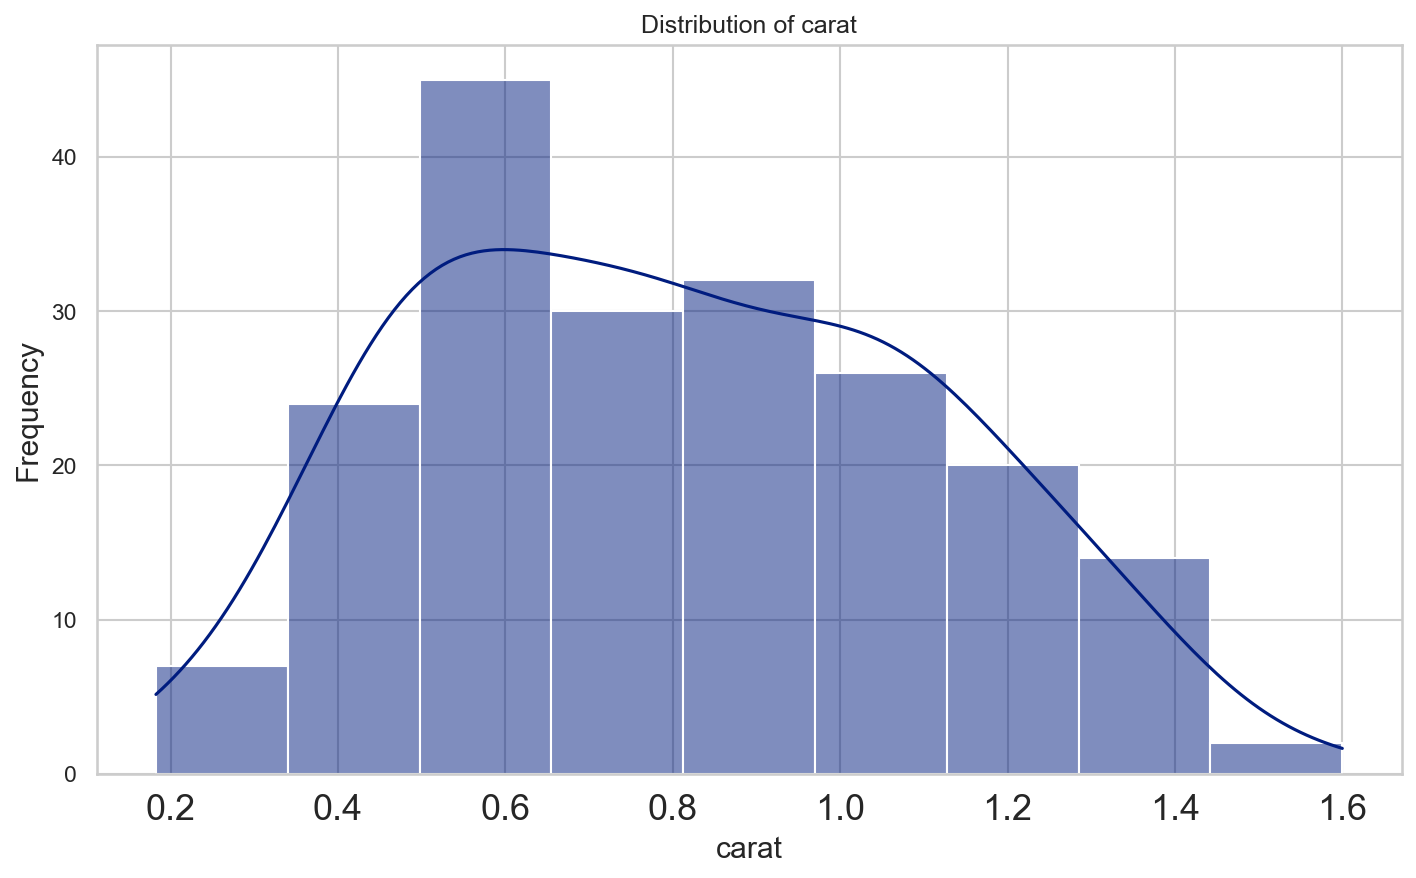

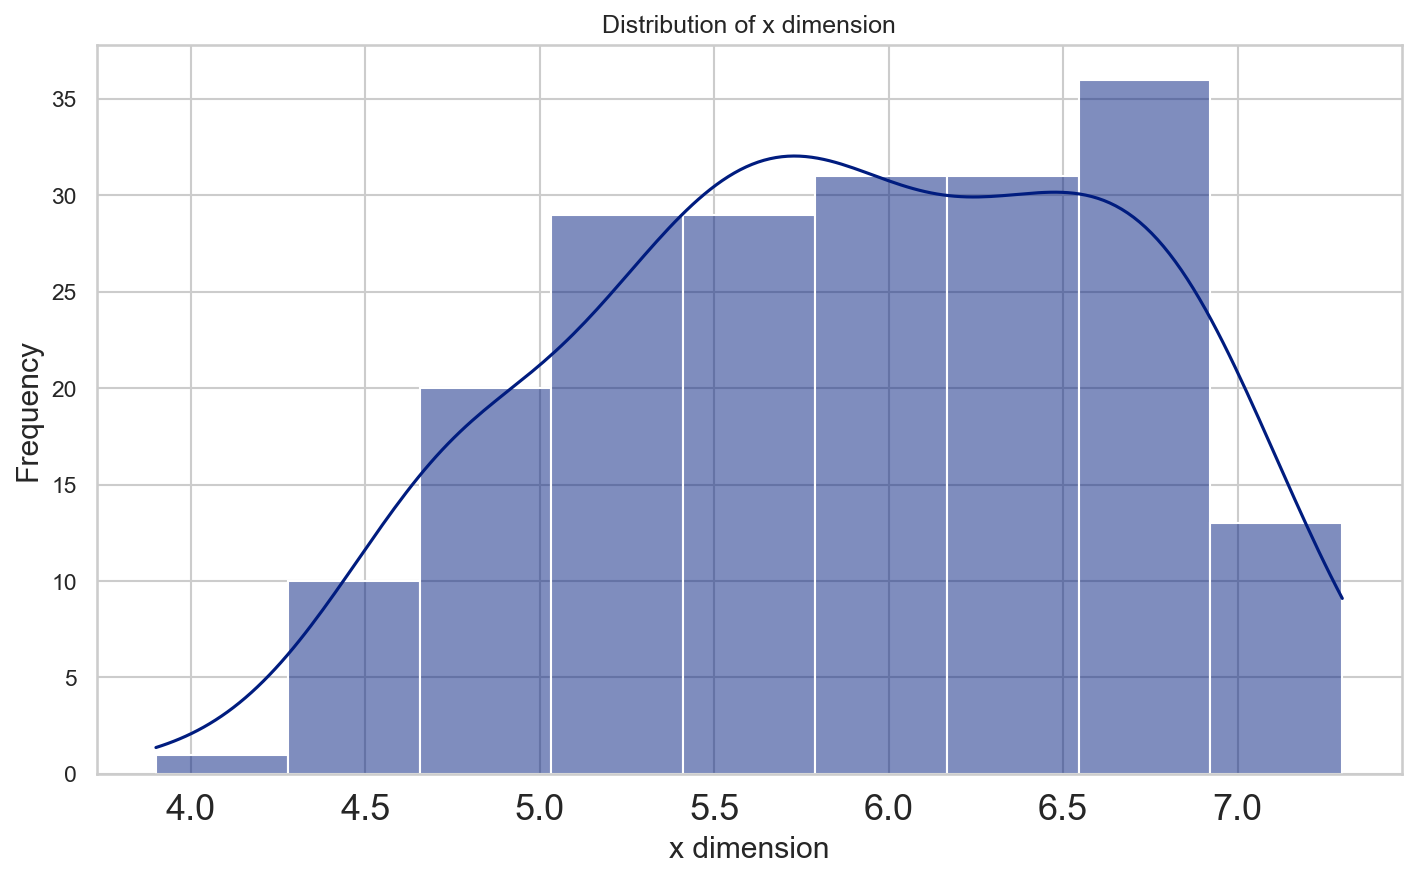

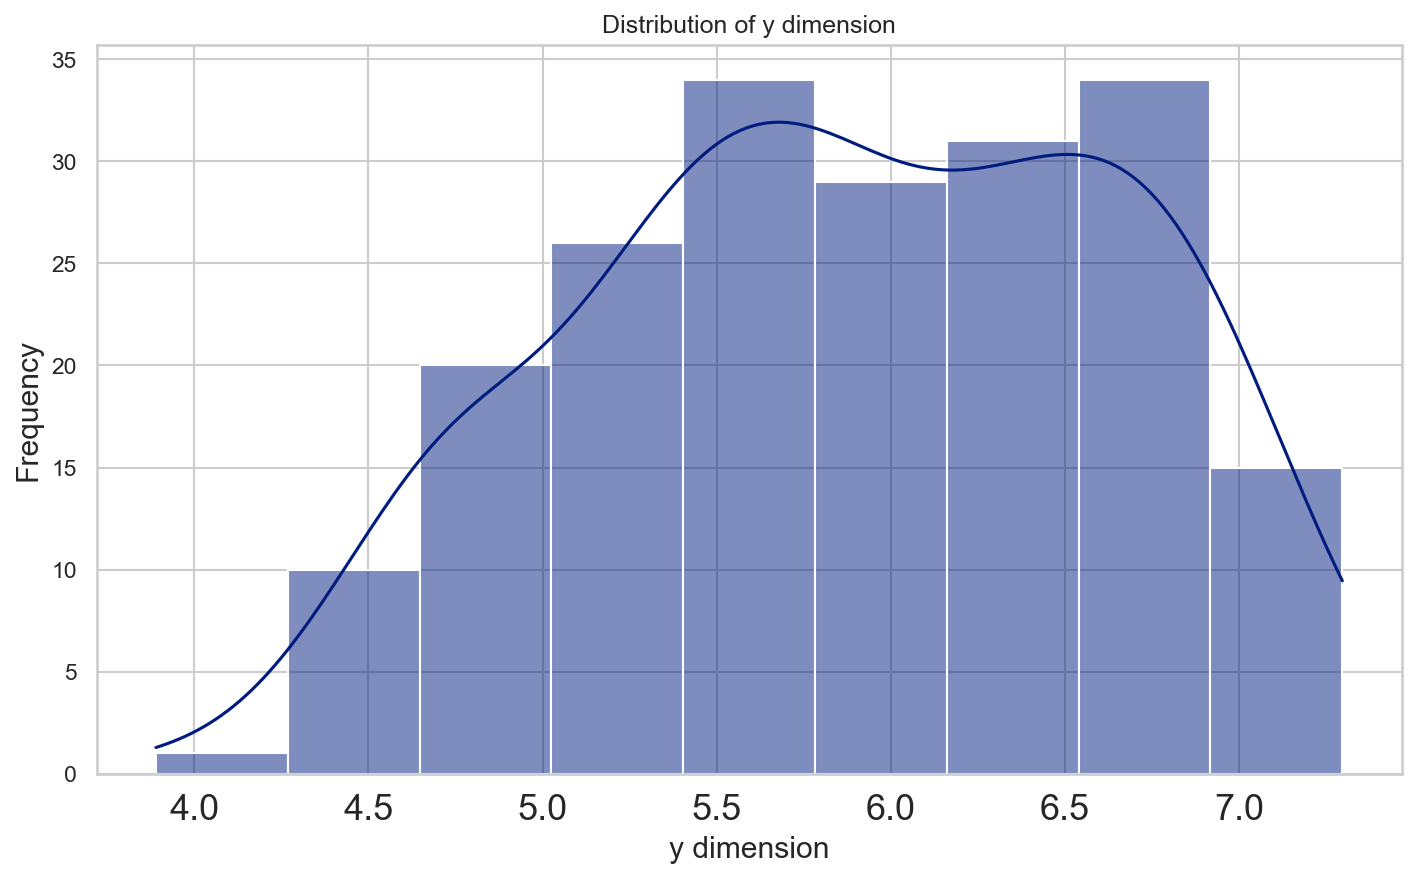

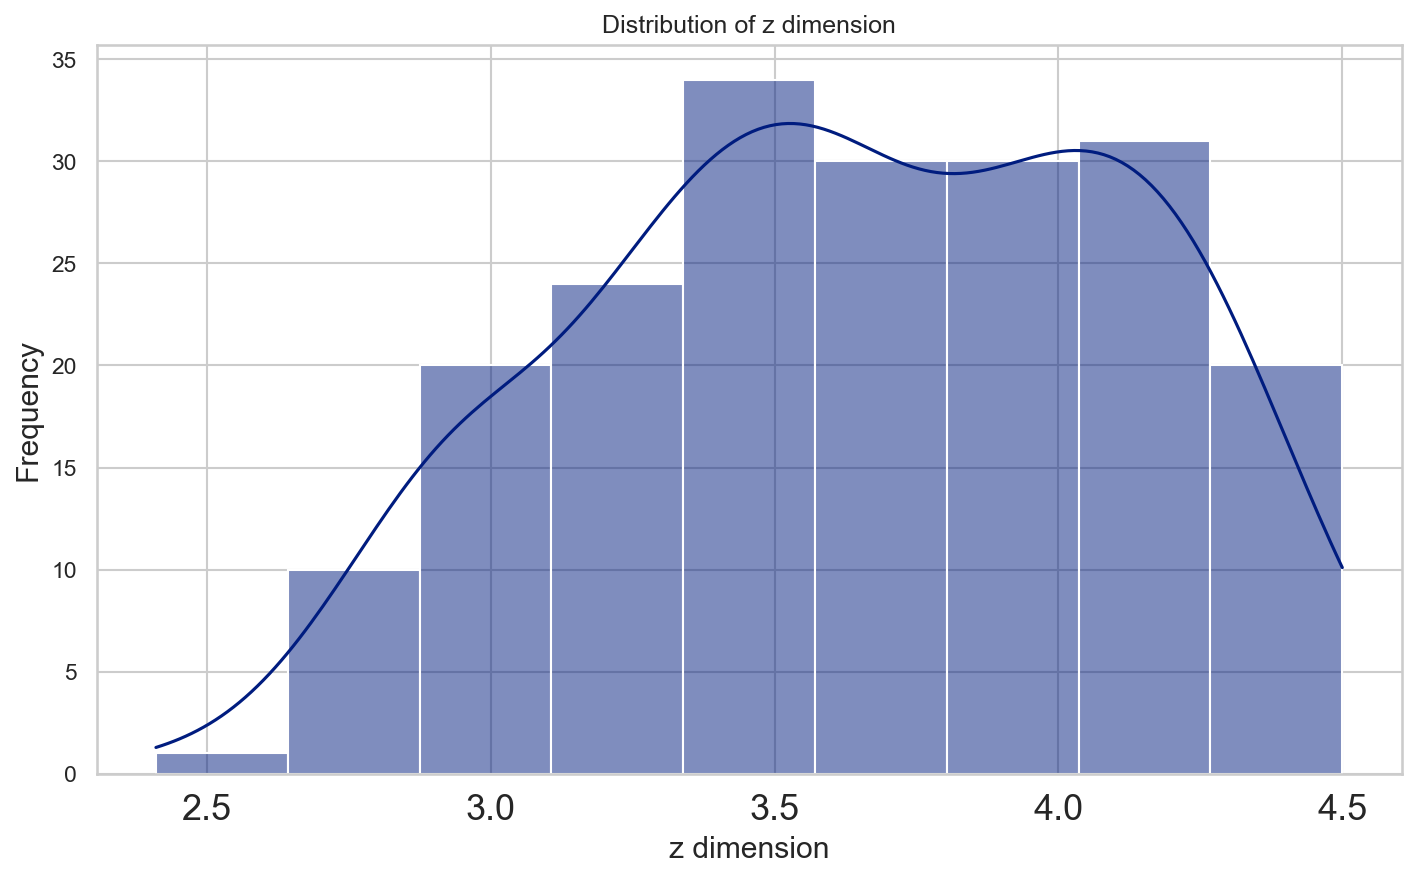

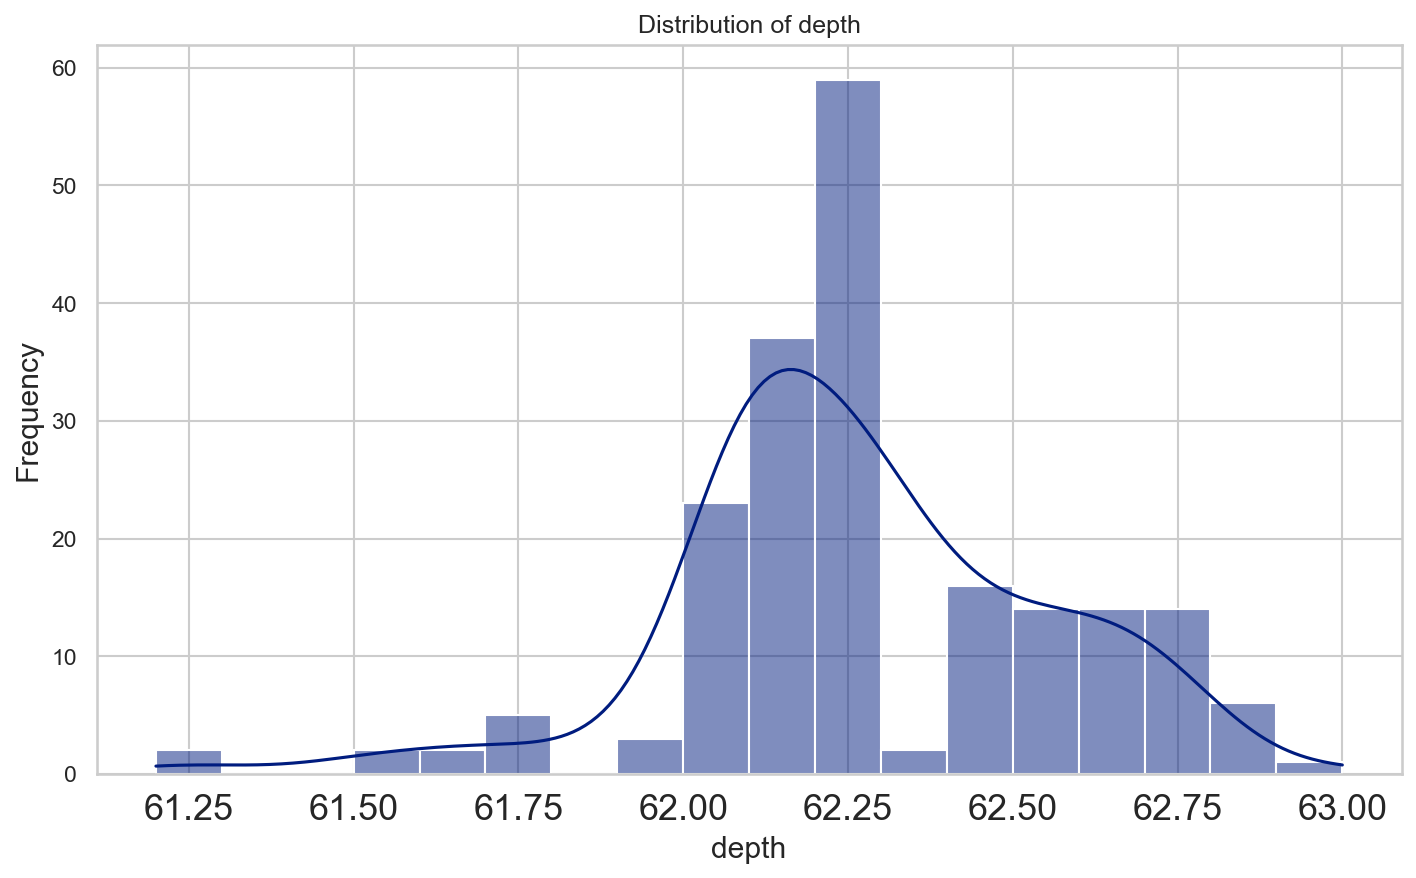

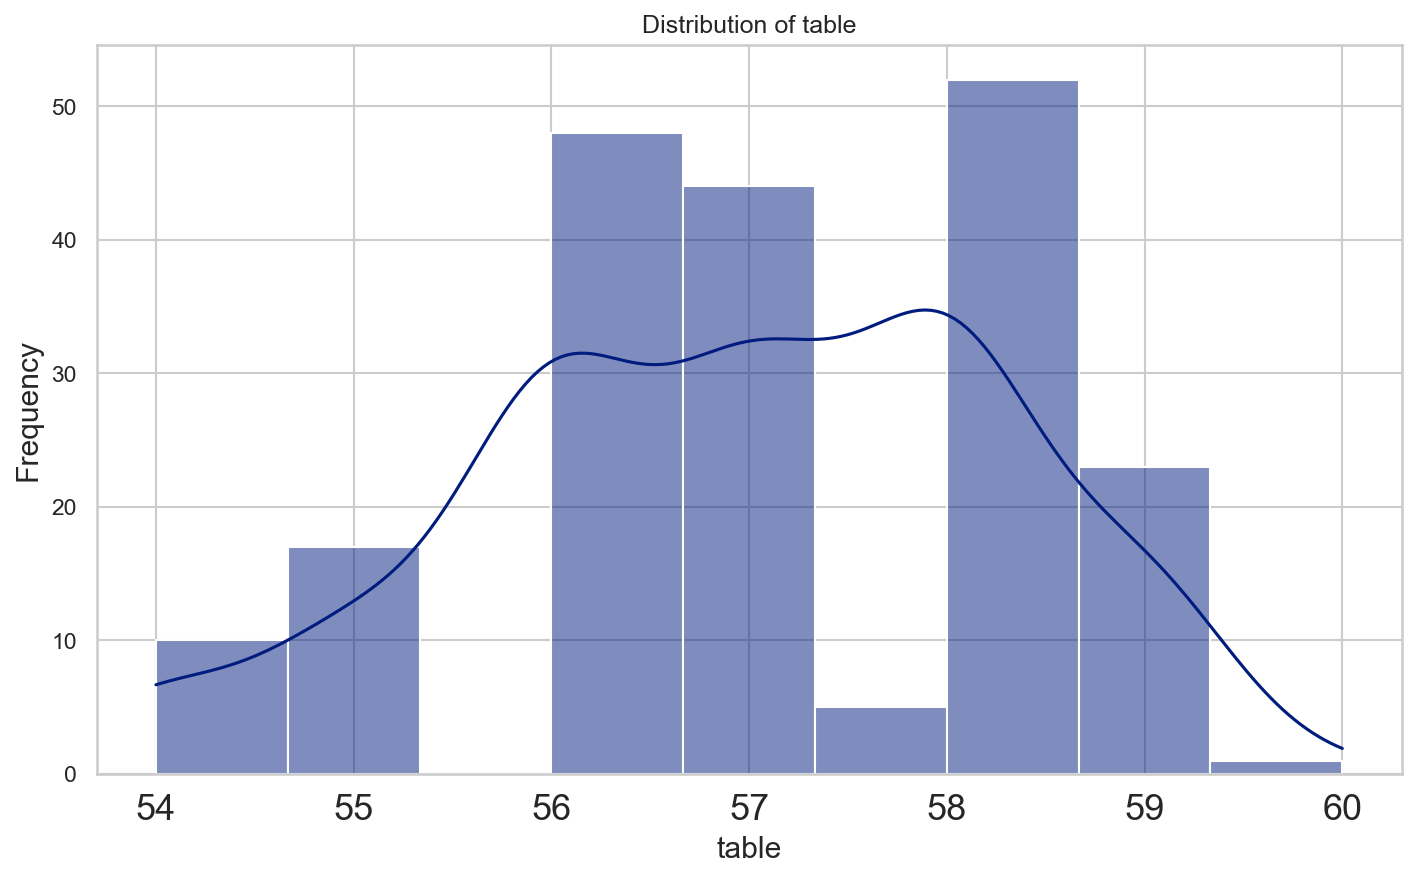

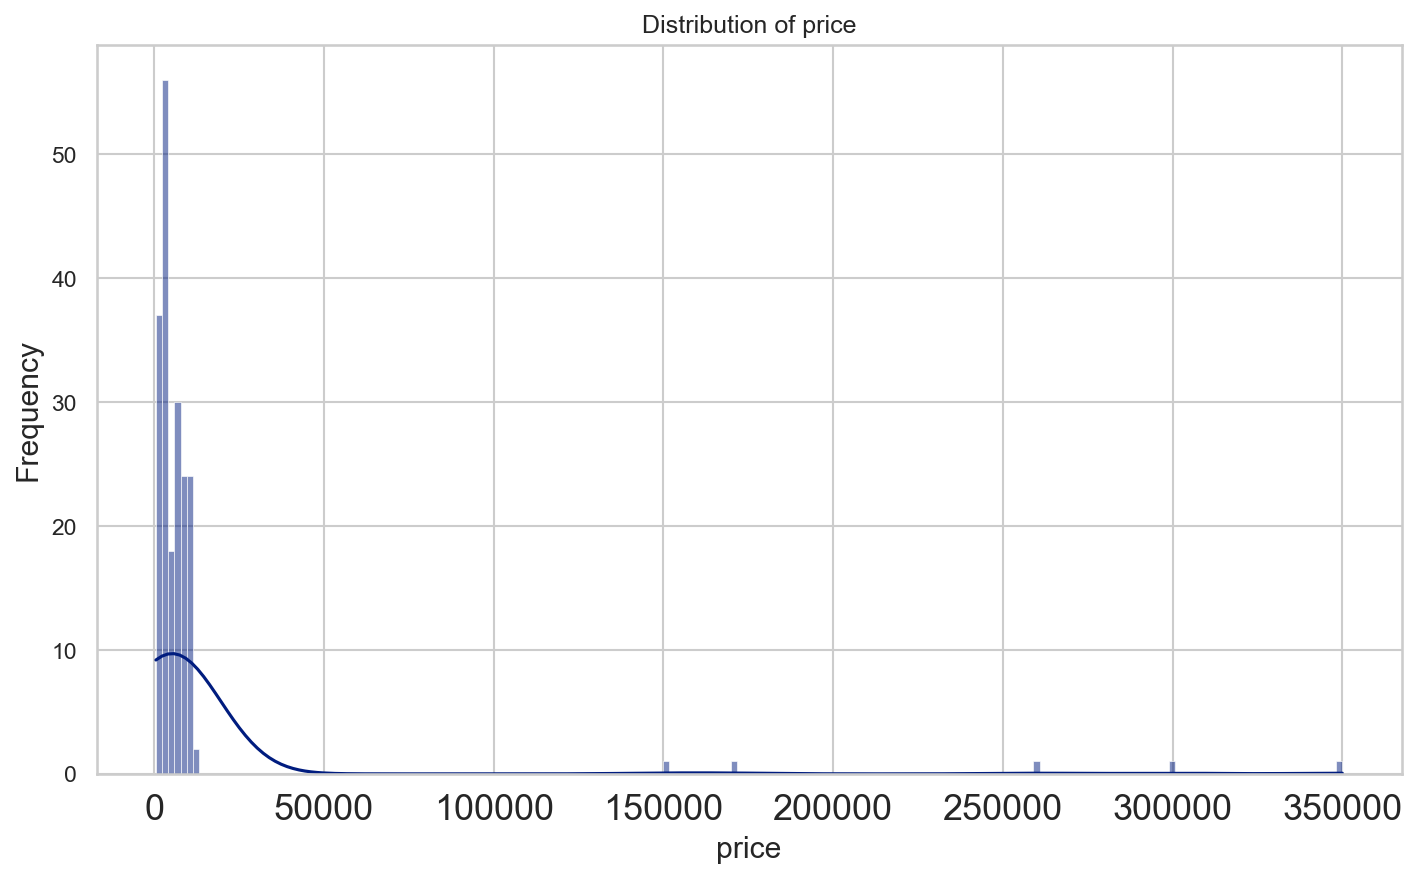

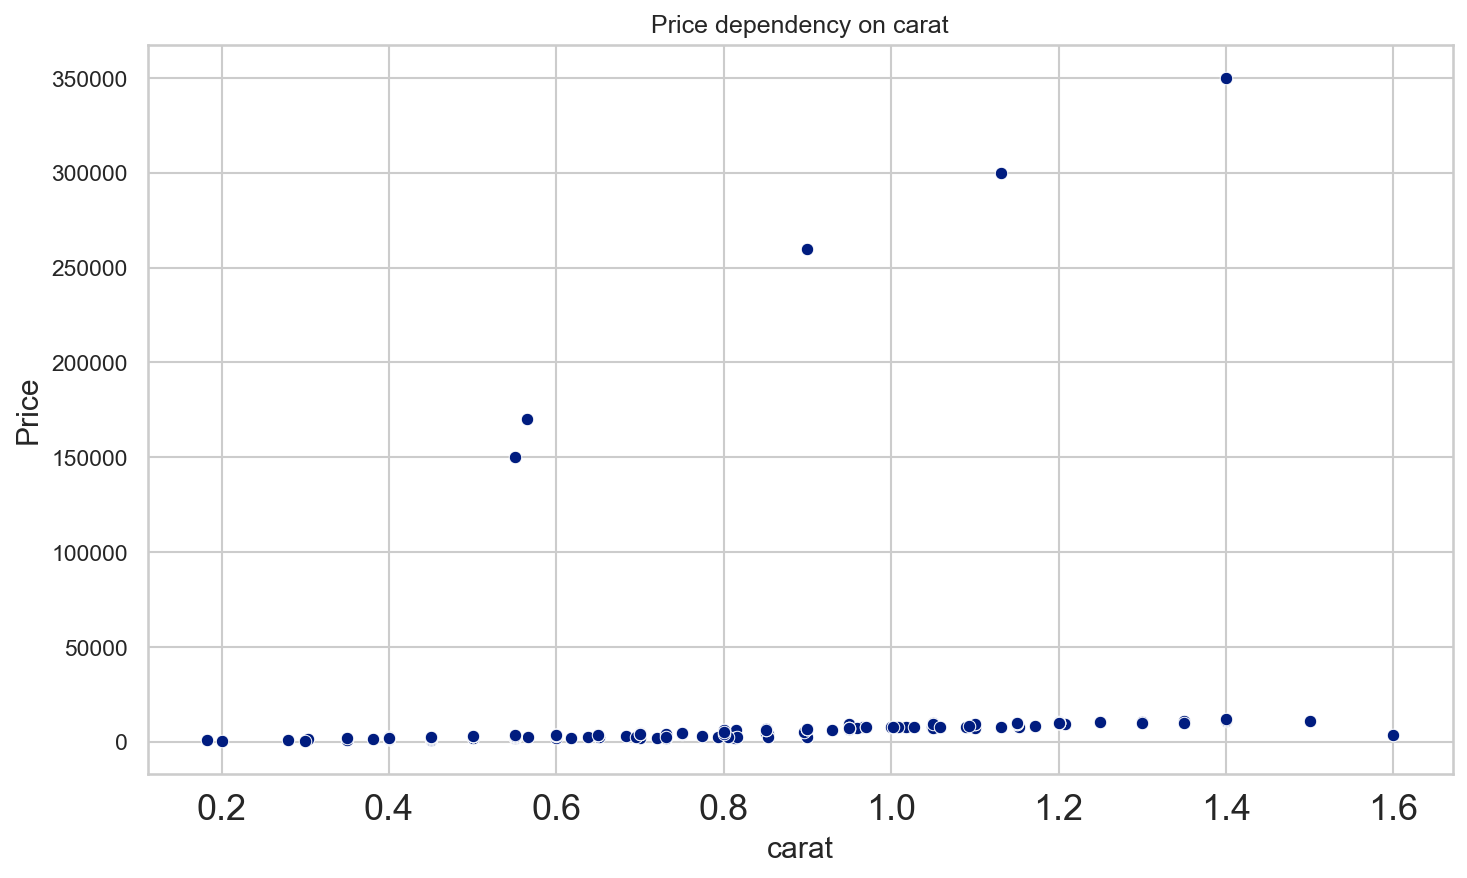

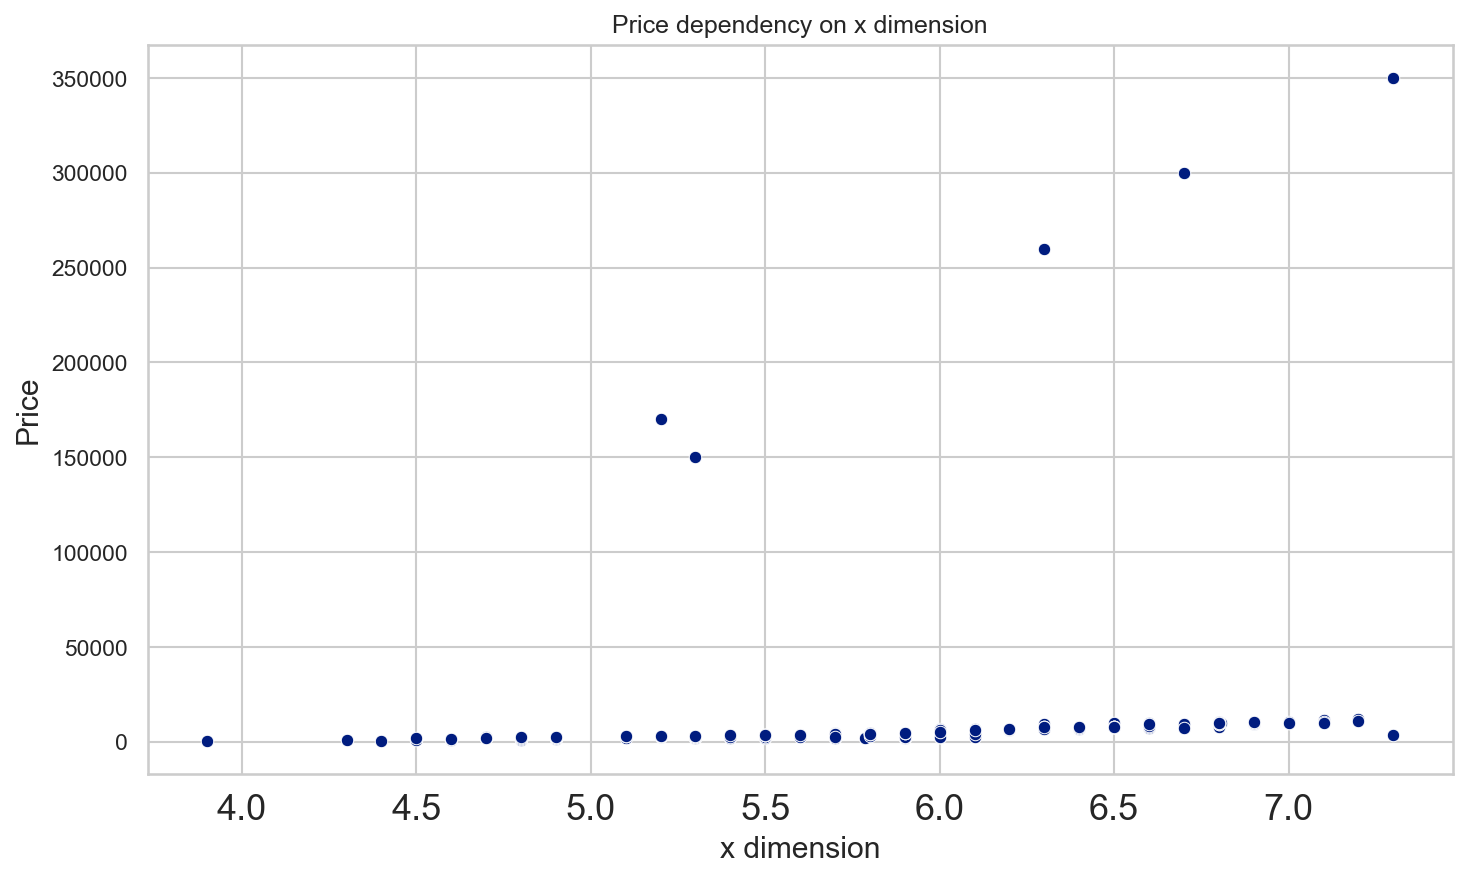

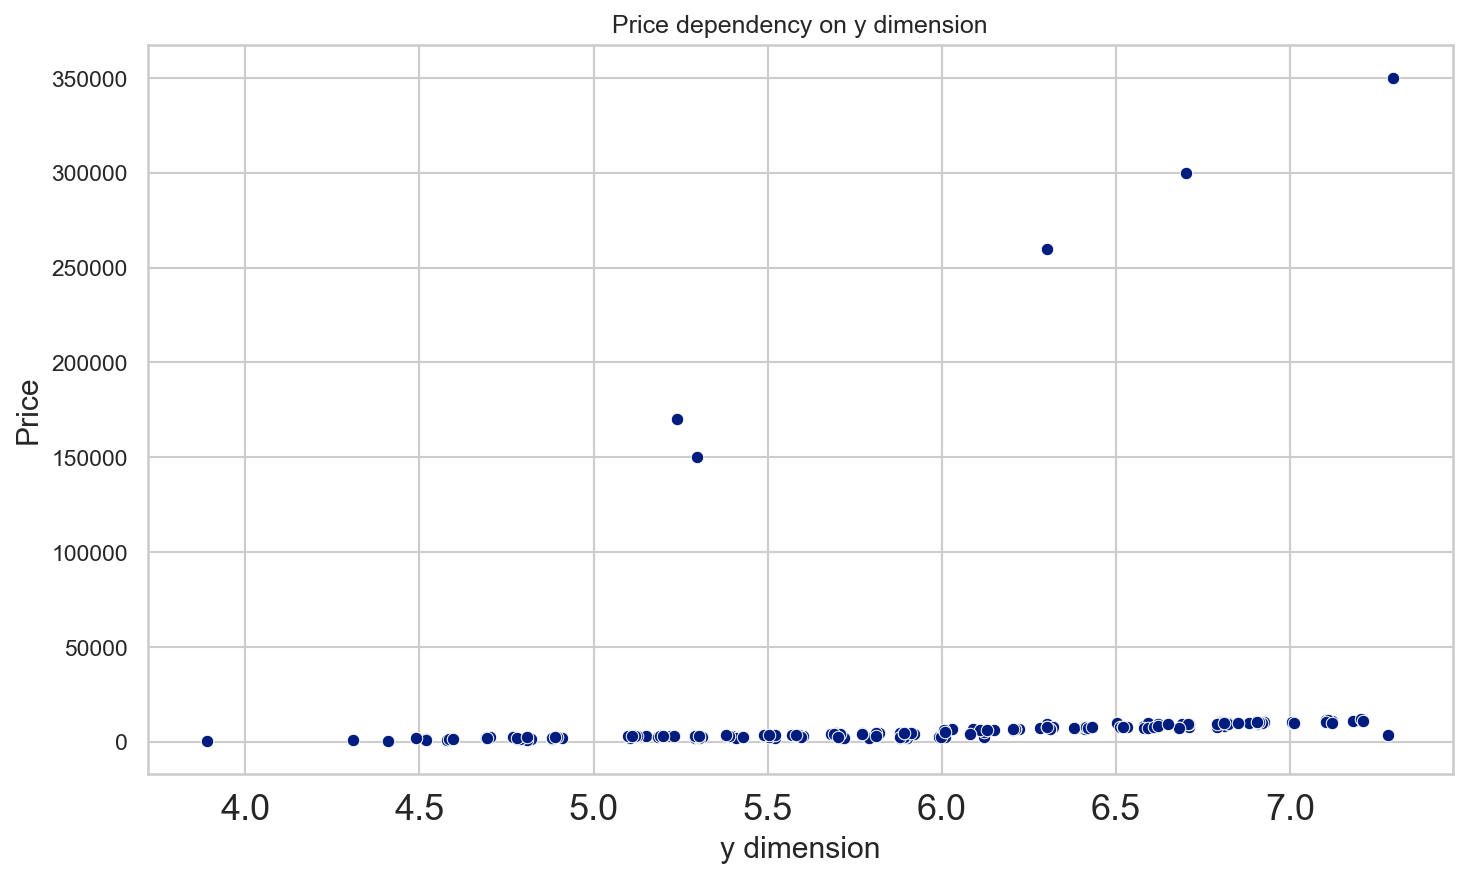

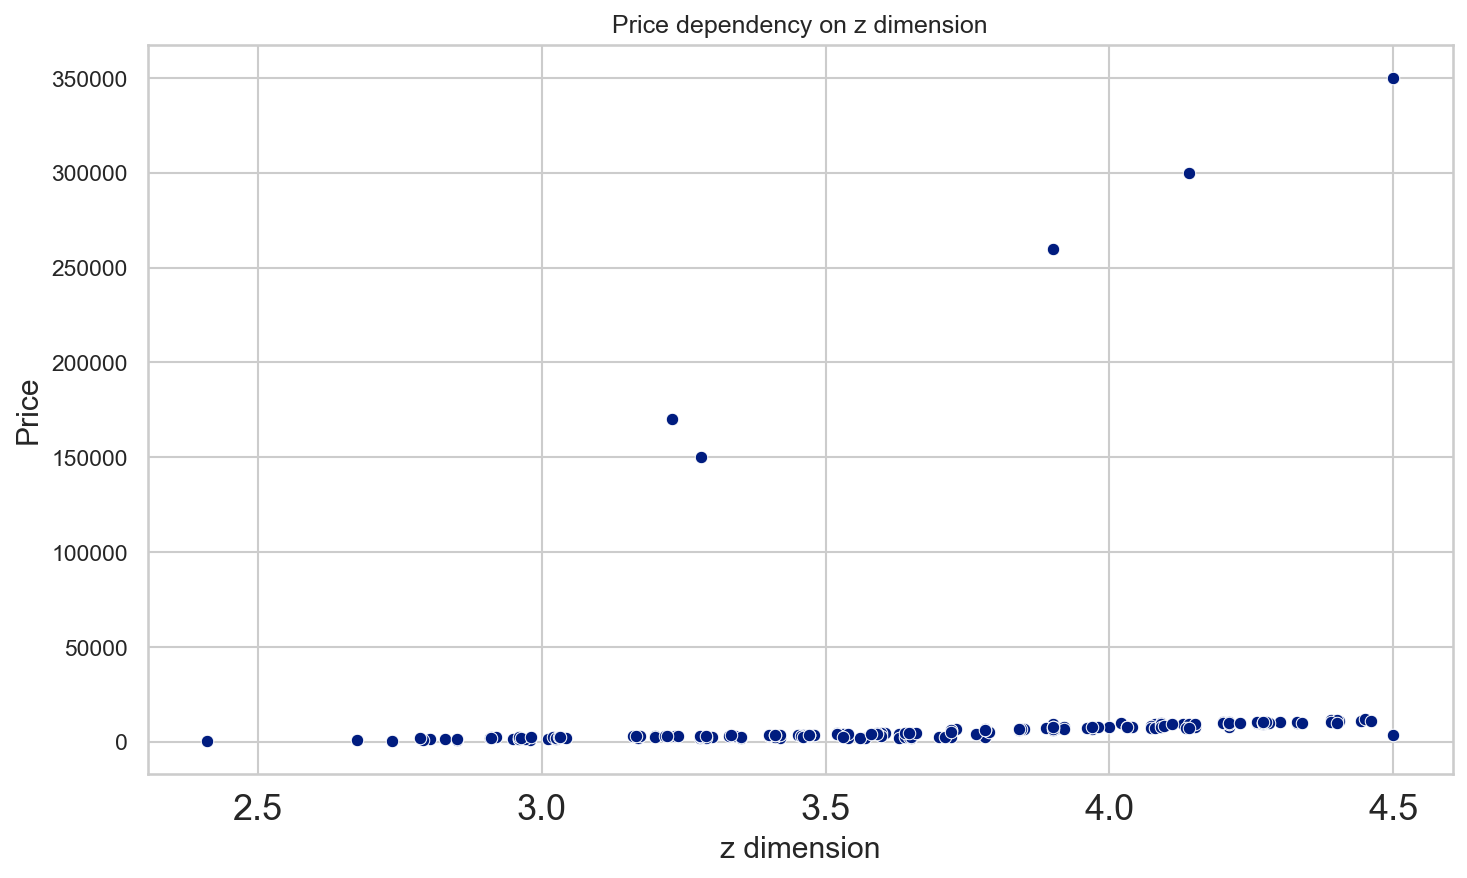

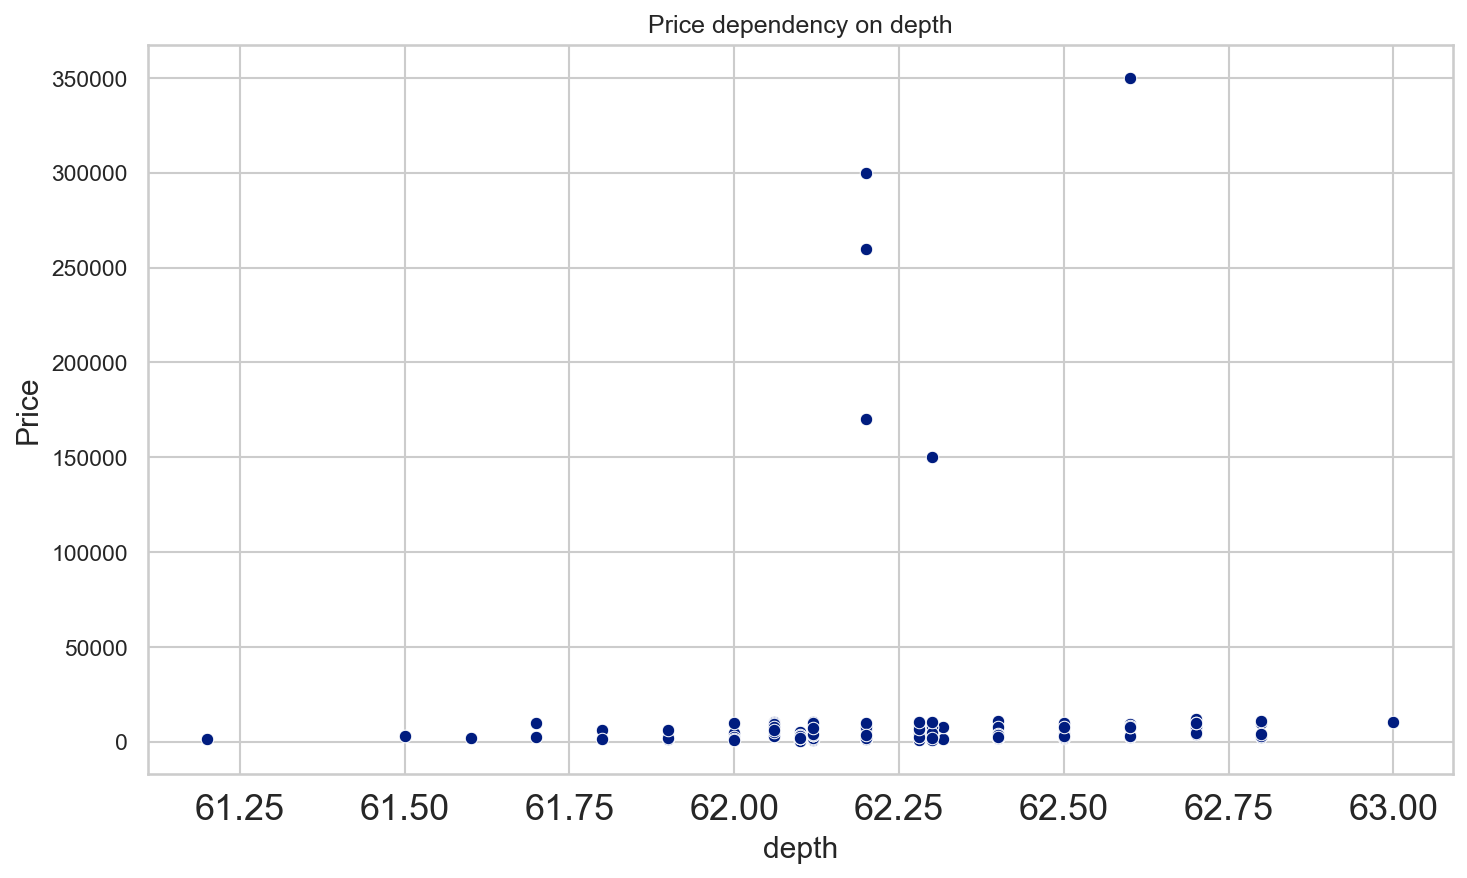

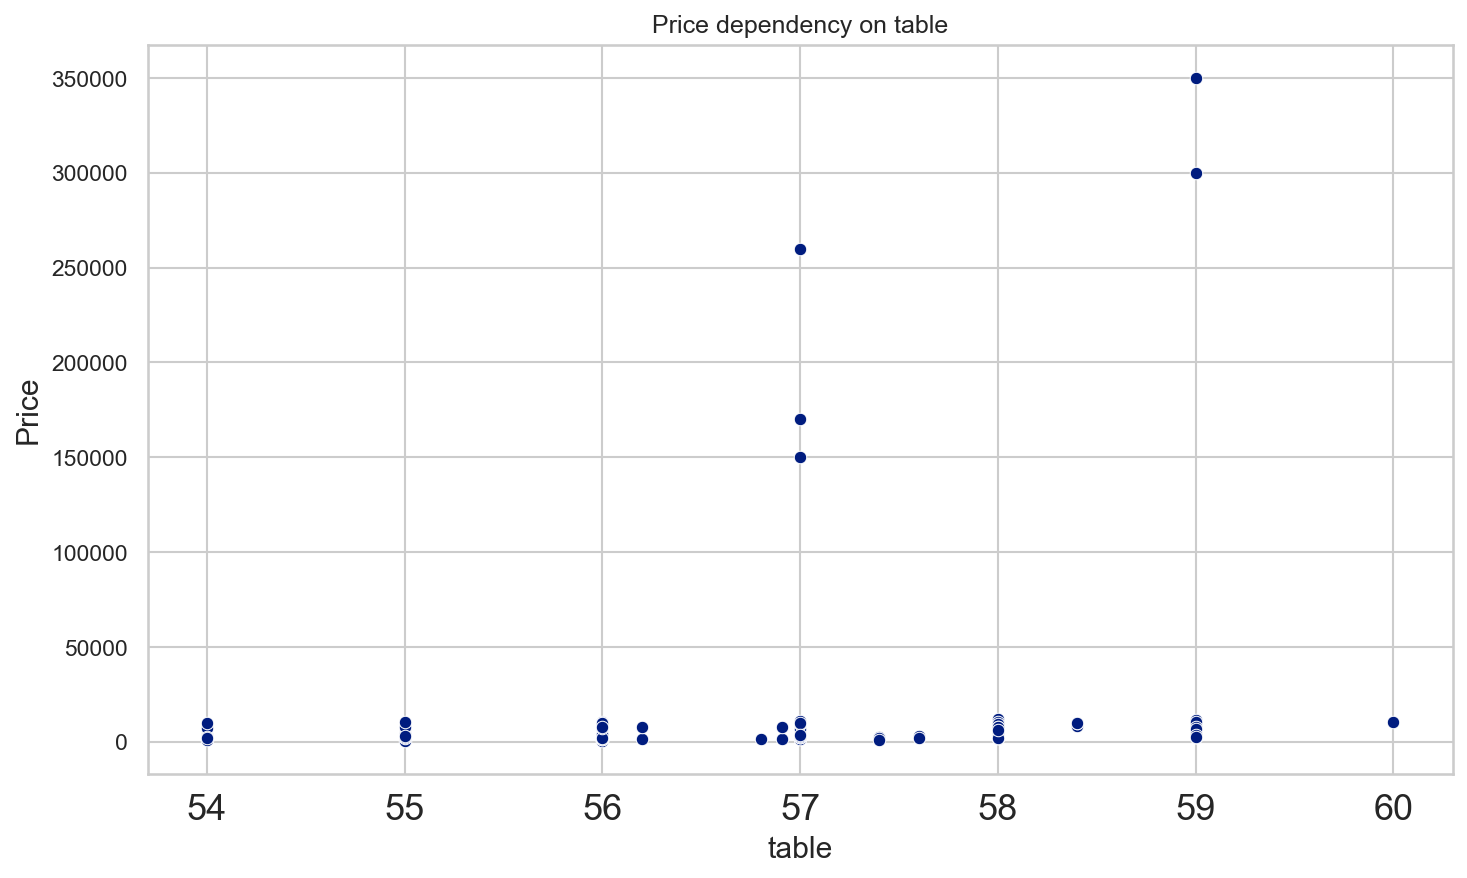

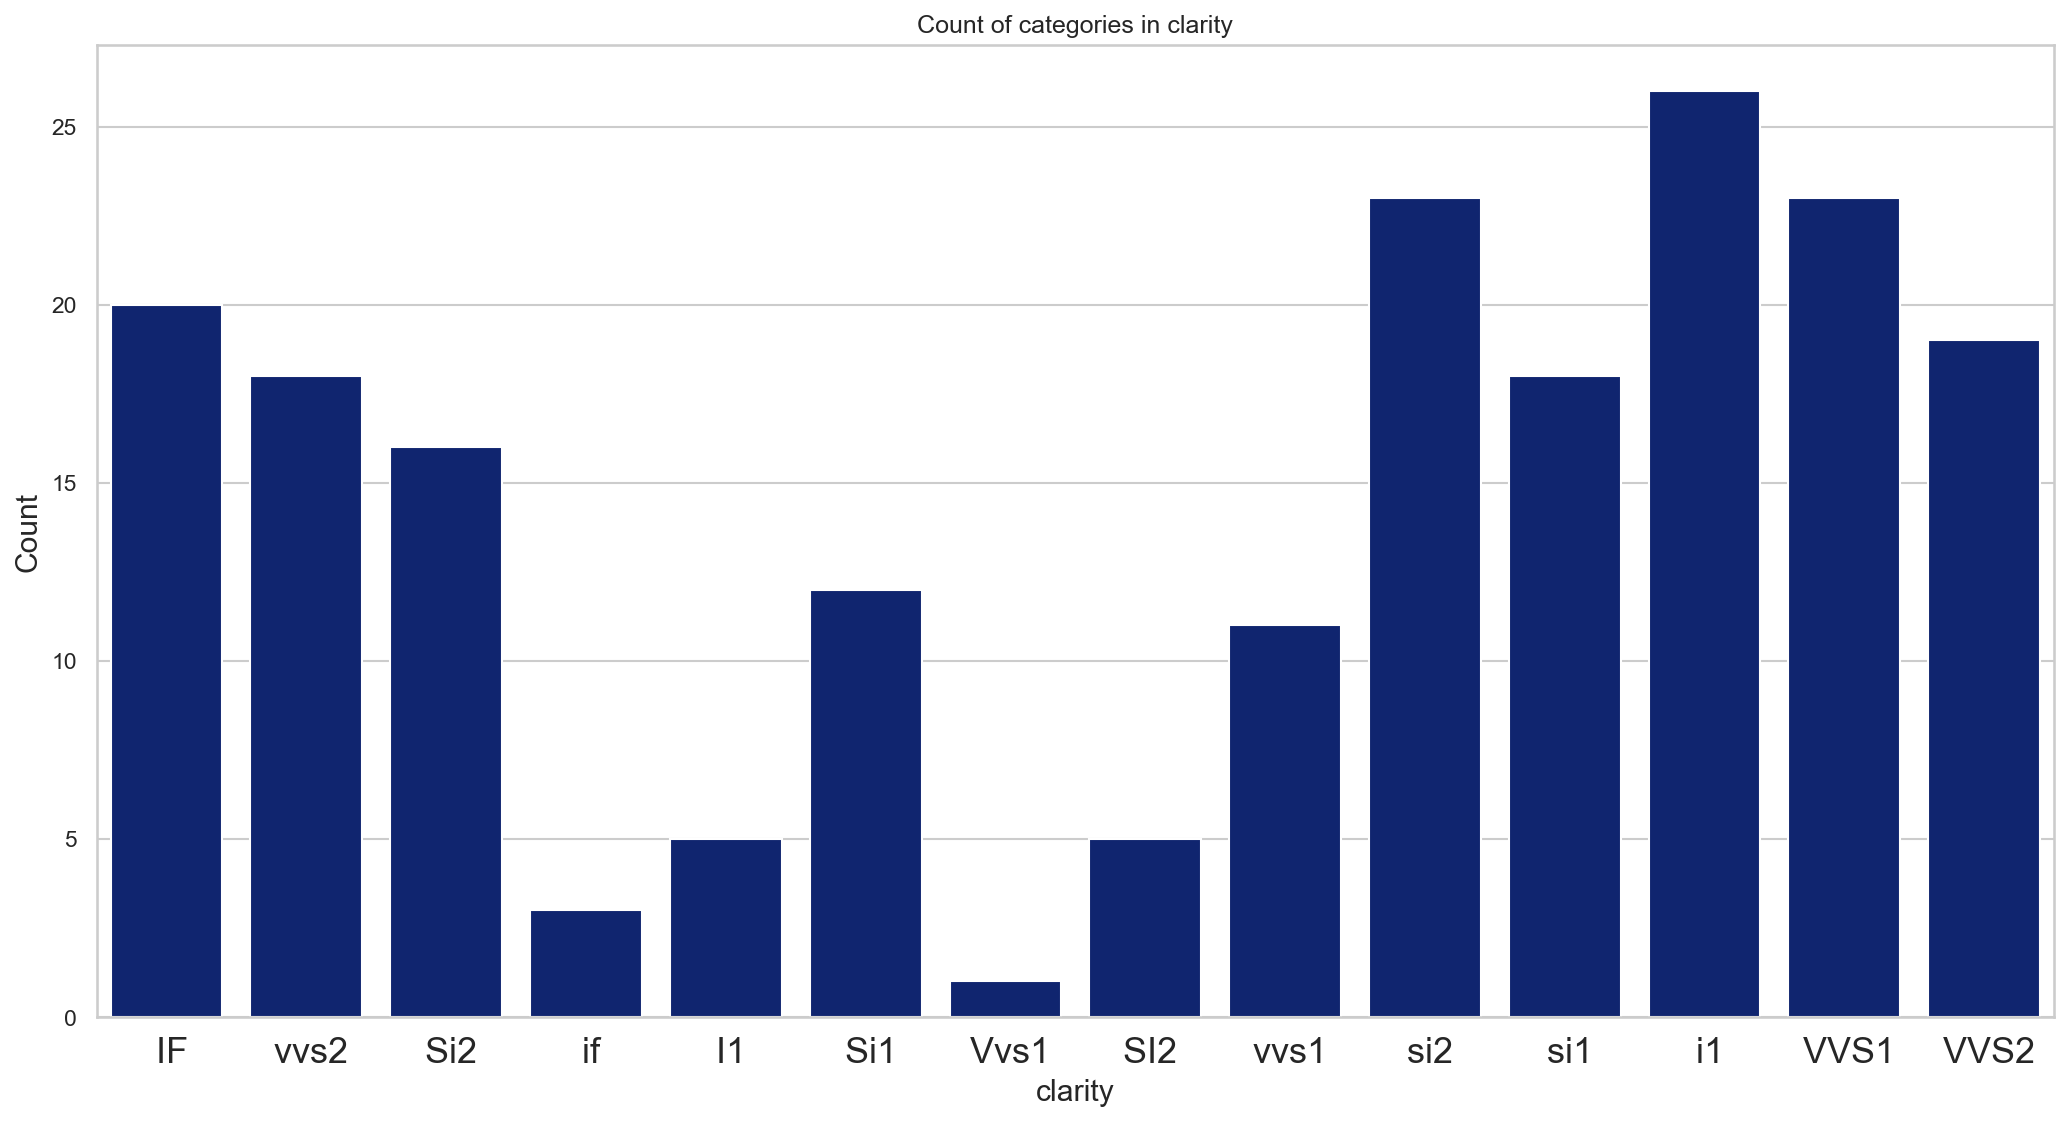

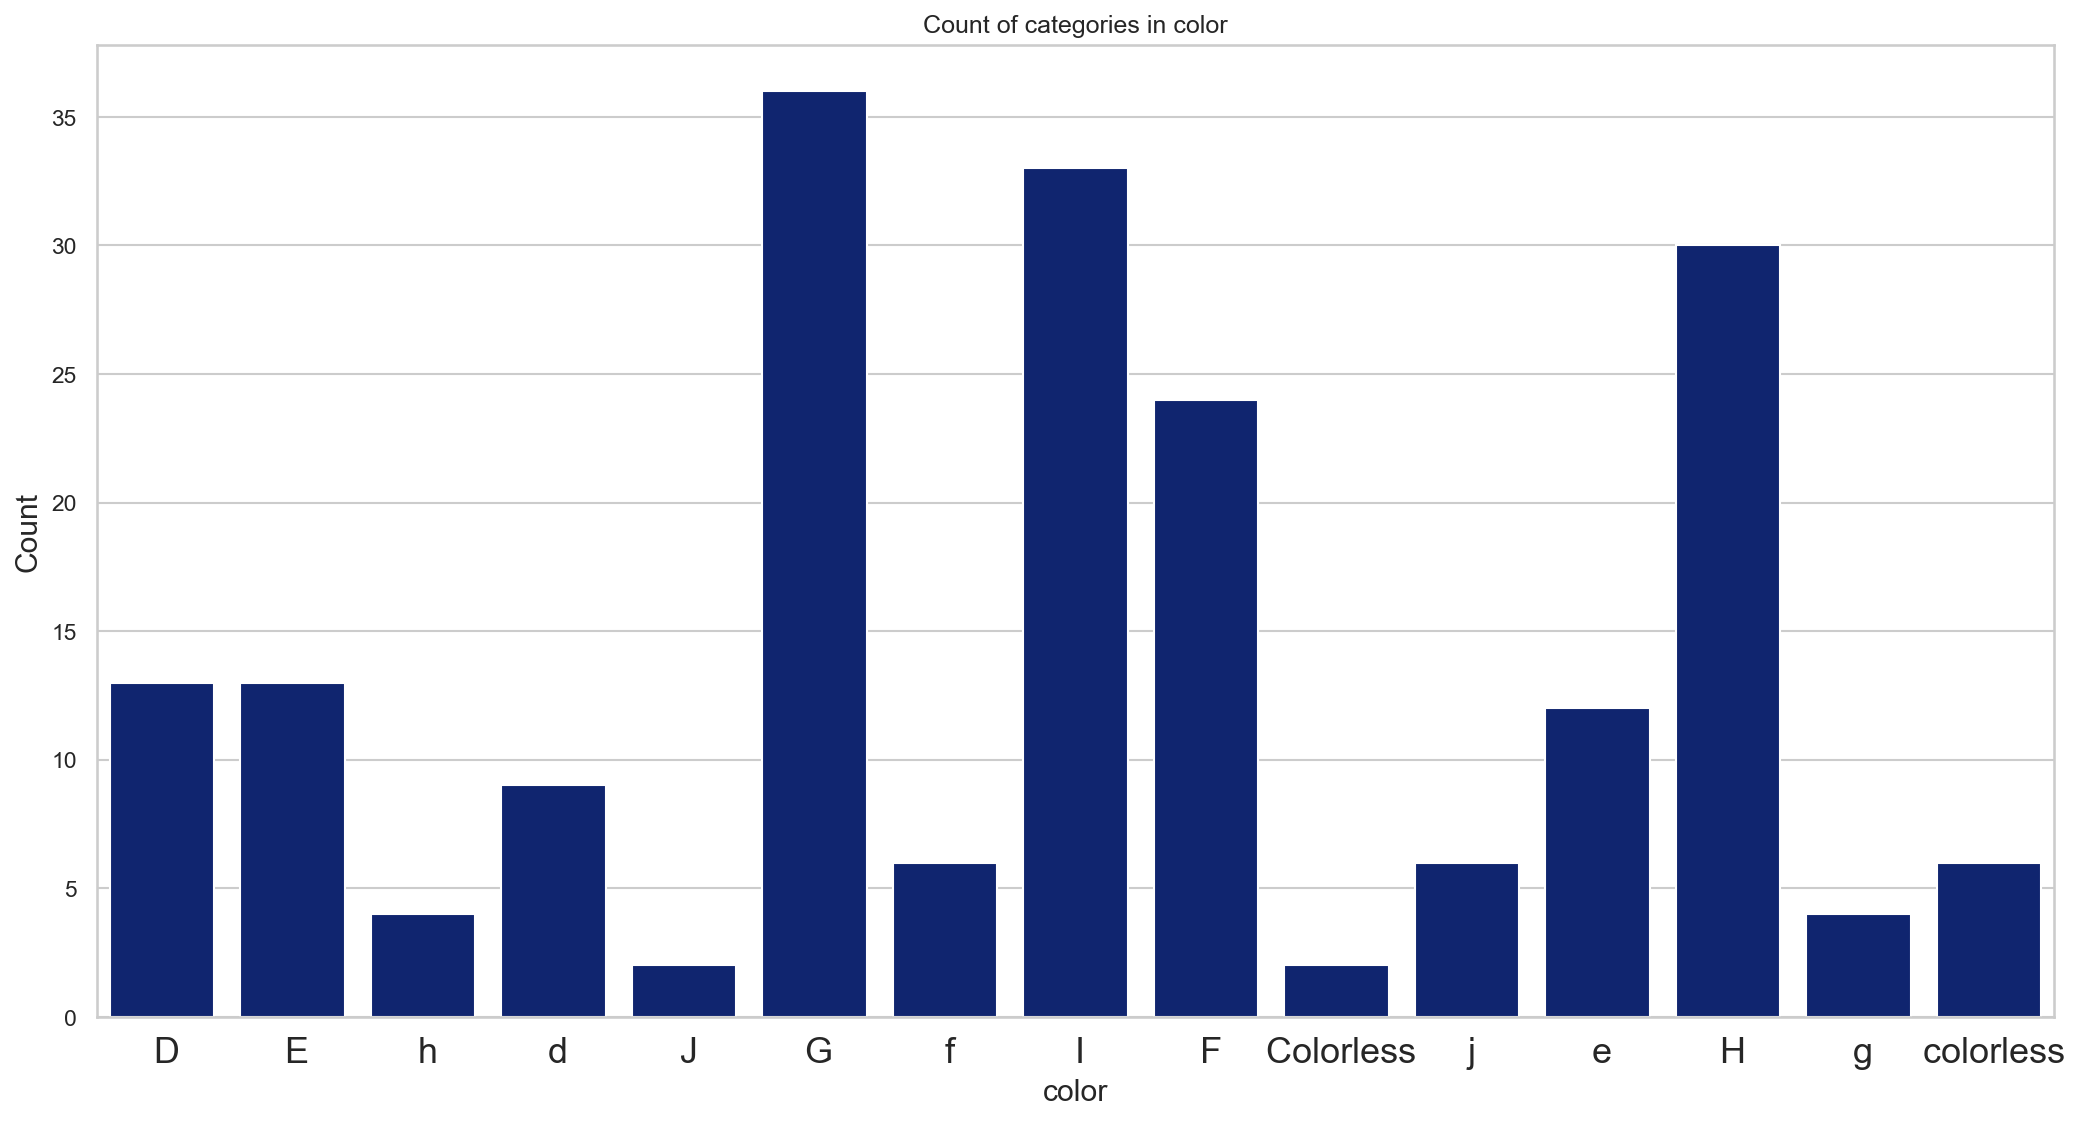

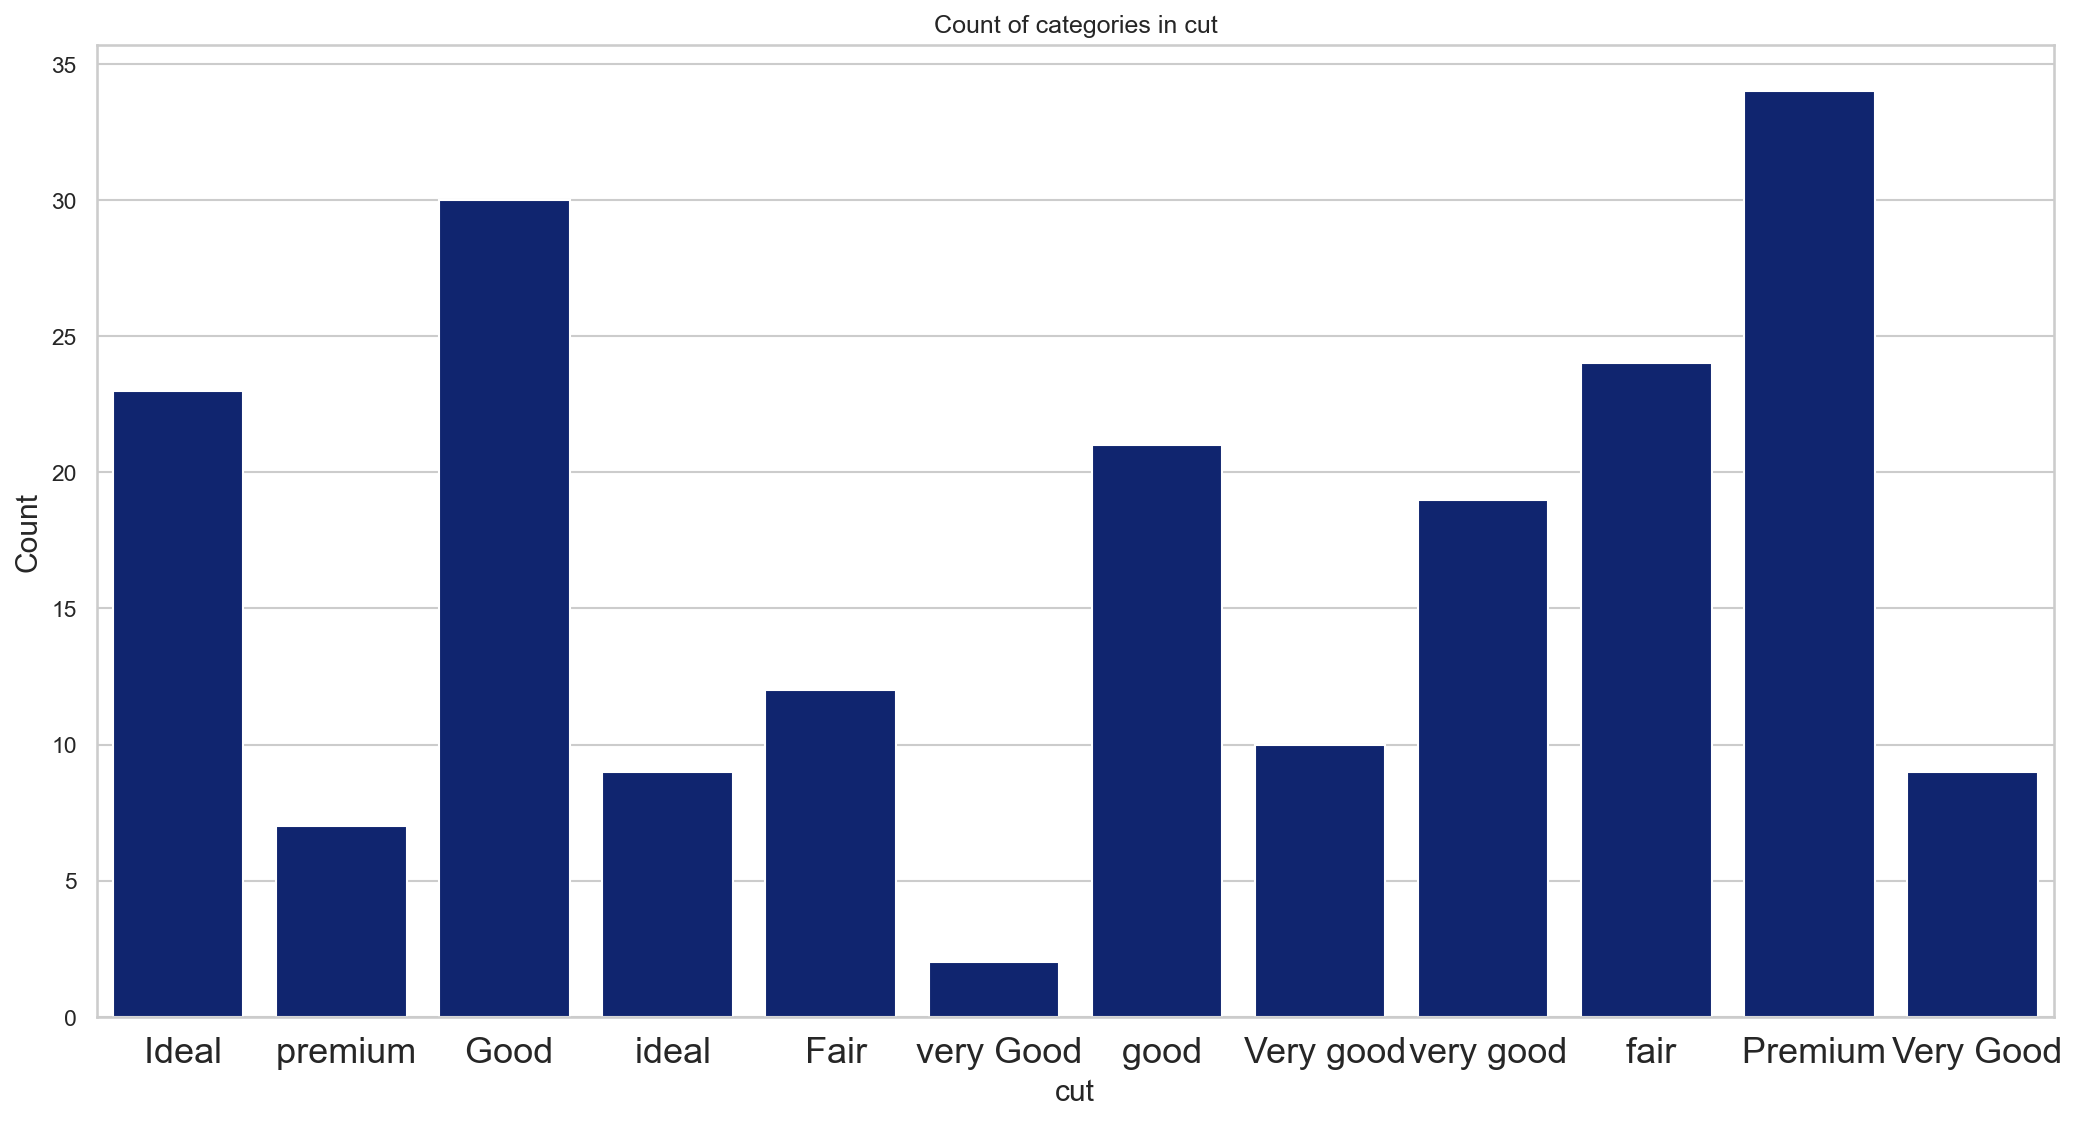

In [469]:
# Wizualizacja rozkładu zmiennych ciągłych
continuous_columns = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']
for column in continuous_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Zależności ceny od innych zmiennych
for column in continuous_columns[:-1]:  # ostatnia kolumna to cena, więc jest pomijana
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[column], y=df['price'])
    plt.title(f'Price dependency on {column}')
    plt.xlabel(column)
    plt.ylabel('Price')
    plt.show()

# Liczebność kategorii dla każdej z kolumn kategorycznych
categorical_columns = ['clarity', 'color', 'cut']
for column in categorical_columns:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=df[column])
    plt.title(f'Count of categories in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()